In [ ]:
class AffineCouplingBlock(Flow):
    """
    Affine Coupling layer including split and merge operation
    """
    def __init__(self, param_map, scale=True, scale_map="exp", split_mode="channel"):
        """Constructor

        Args:
          param_map: Maps features to shift and scale parameter (if applicable)
          scale: Flag whether scale shall be applied
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow
          split_mode: Splitting mode, for possible values see Split class
        """
        super().__init__()
        self.flows = nn.ModuleList([])
        # Split layer
        self.flows += [Split(split_mode)]
        # Affine coupling layer
        self.flows += [AffineCoupling(param_map, scale, scale_map)]
        # Merge layer
        self.flows += [Merge(split_mode)]

    def forward(self, z, condition=None):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for flow in self.flows:
            z, log_det = flow(z)
            log_det_tot += log_det
        return z, log_det_tot

    def inverse(self, z):
        log_det_tot = torch.zeros(z.shape[0], dtype=z.dtype, device=z.device)
        for i in range(len(self.flows) - 1, -1, -1):
            z, log_det = self.flows[i].inverse(z)
            log_det_tot += log_det
        return z, log_det_tot

In [ ]:
class AffineCoupling(Flow):
    """
    Affine Coupling layer as introduced RealNVP paper, see arXiv: 1605.08803
    """


    def __init__(self, param_map, scale=True, scale_map="exp"):
        """Constructor

        Args:
          param_map: Maps features to shift and scale parameter (if applicable)
          scale: Flag whether scale shall be applied
          scale_map: Map to be applied to the scale parameter, can be 'exp' as in RealNVP or 'sigmoid' as in Glow, 'sigmoid_inv' uses multiplicative sigmoid scale when sampling from the model
        """
        super().__init__()
        self.add_module("param_map", param_map)
        self.scale = scale
        self.scale_map = scale_map

    def forward(self, z):
        """
        z is a list of z1 and z2; ```z = [z1, z2]```
        z1 is left constant and affine map is applied to z2 with parameters depending
        on z1

        Args:
          z
        """
        z1, z2 = z
        
    
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == "exp":
                z2 = z2 * torch.exp(scale_) + shift
                log_det = torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid":
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 / scale + shift
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid_inv":
                scale = torch.sigmoid(scale_ + 2)
                z2 = z2 * scale + shift
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError("This scale map is not implemented.")
        else:
            z2 = z2 + param
            log_det = zero_log_det_like_z(z2)
        return [z1, z2], log_det

    def inverse(self, z):
        z1, z2 = z
        param = self.param_map(z1)
        if self.scale:
            shift = param[:, 0::2, ...]
            scale_ = param[:, 1::2, ...]
            if self.scale_map == "exp":
                z2 = (z2 - shift) * torch.exp(-scale_)
                log_det = -torch.sum(scale_, dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid":
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) * scale
                log_det = torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            elif self.scale_map == "sigmoid_inv":
                scale = torch.sigmoid(scale_ + 2)
                z2 = (z2 - shift) / scale
                log_det = -torch.sum(torch.log(scale), dim=list(range(1, shift.dim())))
            else:
                raise NotImplementedError("This scale map is not implemented.")
        else:
            z2 = z2 - param
            log_det = zero_log_det_like_z(z2)
        return [z1, z2], log_det



In [ ]:

class MLP(nn.Module):
    """
    A multilayer perceptron with Leaky ReLU nonlinearities
    """

    def __init__(
        self,
        layers,
        leaky=0.0,
        score_scale=None,
        output_fn=None,
        output_scale=None,
        init_zeros=False,
        dropout=None,
    ):
        """
        layers: list of layer sizes from start to end
        leaky: slope of the leaky part of the ReLU, if 0.0, standard ReLU is used
        score_scale: Factor to apply to the scores, i.e. output before output_fn.
        output_fn: String, function to be applied to the output, either None, "sigmoid", "relu", "tanh", or "clampexp"
        output_scale: Rescale outputs if output_fn is specified, i.e. ```scale * output_fn(out / scale)```
        init_zeros: Flag, if true, weights and biases of last layer are initialized with zeros (helpful for deep models, see [arXiv 1807.03039](https://arxiv.org/abs/1807.03039))
        dropout: Float, if specified, dropout is done before last layer; if None, no dropout is done
        """
        super().__init__()
        net = nn.ModuleList([])
        for k in range(len(layers) - 2):
            net.append(nn.Linear(layers[k], layers[k + 1]))
            net.append(nn.LeakyReLU(leaky))
        if dropout is not None:
            net.append(nn.Dropout(p=dropout))
        net.append(nn.Linear(layers[-2], layers[-1]))
        if init_zeros:
            nn.init.zeros_(net[-1].weight)
            nn.init.zeros_(net[-1].bias)
        if output_fn is not None:
            if score_scale is not None:
                net.append(utils.ConstScaleLayer(score_scale))
            if output_fn == "sigmoid":
                net.append(nn.Sigmoid())
            elif output_fn == "relu":
                net.append(nn.ReLU())
            elif output_fn == "tanh":
                net.append(nn.Tanh())
            elif output_fn == "clampexp":
                net.append(utils.ClampExp())
            else:
                NotImplementedError("This output function is not implemented.")
            if output_scale is not None:
                net.append(utils.ConstScaleLayer(output_scale))
        self.net = nn.Sequential(*net)

    def forward(self, x):
        return self.net(x)

In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits

import os

from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import torch
import flowtorch.bijectors as bij
import flowtorch.distributions as dist

In [4]:
import normflows as nf
from tqdm import tqdm

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class Conditinoal_Encoder(nn.Module):
    """Convolutional dense encoder for conditioning the generative model.
    See Fig. 4 of paper: https://arxiv.org/abs/2006.04731

    :param in_features: Number of input features
    :param enc_block_layers: list of the number of dense layers in each desired dense block
    :param init_features: Number of channels after te first convolution, defaults to 48
    :param output_features: Number of output channel features (will be twice this value
        since final value will be turned into mu and stds for latent variables), defaults to 8
    :type output_features: int, optional
    :param cond_features: Number of conditional feature channels, defaults to 8
    :type cond_features: int, optional
    :param cglow_upscale: The factor to upscale the features from the dense encode 
        before passing them to the generative model, defaults to 1
    :type cglow_upscale: int, optional
    :param bn_size: number of features after bottleneck if enabled, defaults to 8
    :type bn_size: int, optional
    :param drop_rate: Dropout rate, defaults to 0.
    :type drop_rate: float, optional
    """
    def __init__(self, init_features, 
                enc_block_layers, 
                hidden_features,
                output_dim=8, 
                drop_rate=0
                ):
        """Constructor method""" 
        super(Conditinoal_Encoder, self).__init__()
        # First encoding module

        self.encoding_blocks = []

        # Construct dense block layers
        num_feat = init_features
        for i in range(enc_block_layers):
            block = nn.Sequential()
            block.add_module('encode_mlp{}'.format(i), self.mlp_block(num_feat, hidden_features[i], drop_rate=drop_rate))
            num_feat = hidden_features[i]

            self.encoding_blocks.append(block)
            
        
        block.add_module('encode_mlp{}'.format(i+1),
            self.mlp_block(num_feat, 2*output_dim, drop_rate=drop_rate))
        
        # Convert lists to module lists
        self.encoding_blocks = nn.ModuleList(self.encoding_blocks)
        
    def mlp_block(self, in_features, out_features, drop_rate=0):
        """Encoding transition convolution placed between dense blocks, halves feature map size

        :param in_features: Number of input features
        :param output_features: Number of output features
        :param drop_rate: Dropout rate, defaults to 0.
        
        
            - encoder_trans: Transition PyTorch module
        :rtype: nn.Module
        """
        block = nn.Sequential(nn.Linear(in_features, out_features))
        block.add_module('linear1', nn.Linear(in_features, out_features))
        block.add_module('relu1', nn.ReLU(inplace=False))
        if drop_rate > 0:
            block.add_module('dropout1', nn.Dropout(p=drop_rate))

        return block

    def forward(self, x):
        """Encoder forward pass

        :param x: [B, in_features, H, W] input feature tensor
        :type x: torch.Tensor
        :returns:
            - out: Final encoder output
            - c_out: List of conditional output states to conditional the generative model
        :rtype: (torch.Tensor, list)
        """

        c_out = []
        for i, block in enumerate(self.encoding_blocks):
            # Pass though dense block
            dense_out = block(x)
            c_out.append(dense_out)
            out = dense_out
        return out, c_out


## EXAMPLE IN GITHUB

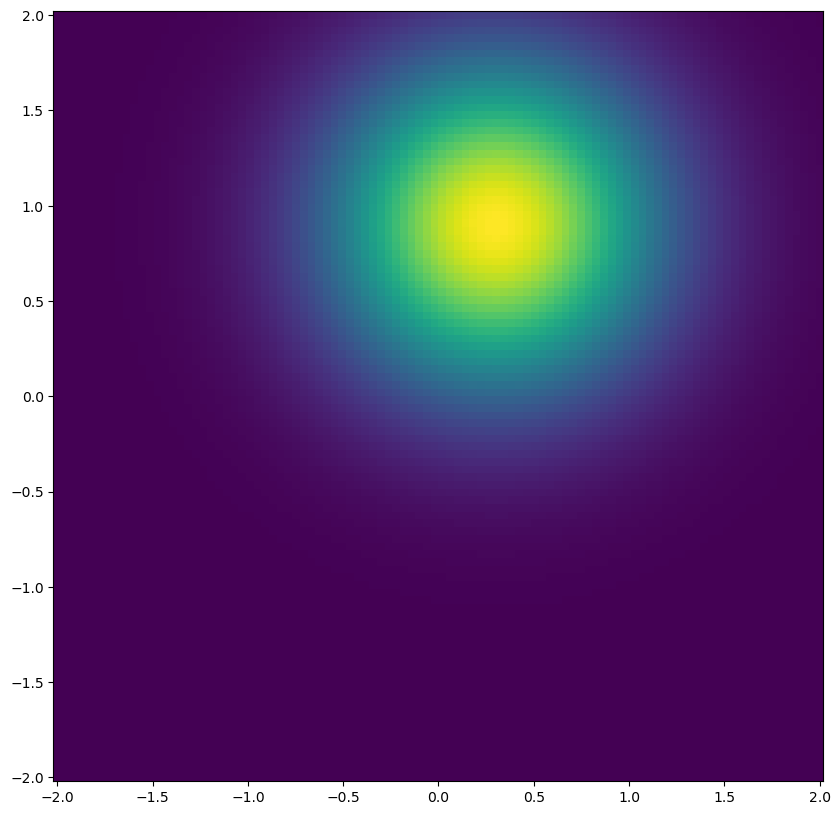

In [87]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 4

# Plot target
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(-2, 2, grid_size), torch.linspace(-2, 2, grid_size), indexing='ij')
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz), 
                          0.6 * torch.ones_like(zz)], dim=-1)
logp = target.log_prob(zz, context_plot)
p_target = torch.exp(logp).view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, p_target, shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

In [88]:
# Define flows
K = 4

latent_size = 2
hidden_units = 128
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)

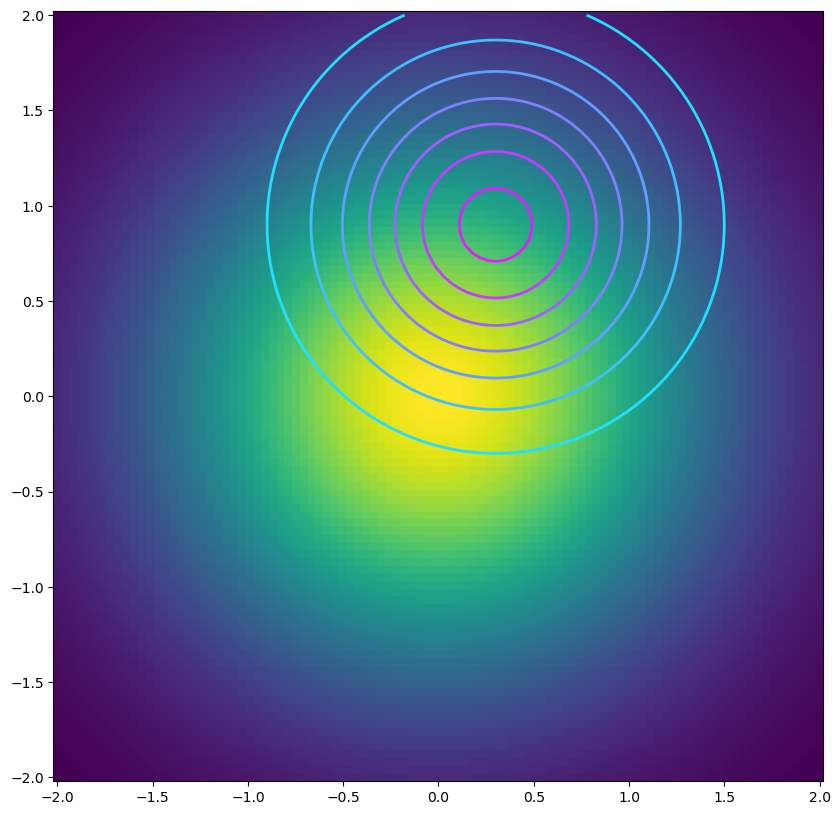

In [89]:
# Plot initial flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [90]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device), 
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)], 
                        dim=-1)
    x = target.sample(batch_size, context)
    
    # Compute loss
    loss = model.forward_kld(x, context)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: isnan(): argument 'input' (position 1) must be Tensor, not tuple

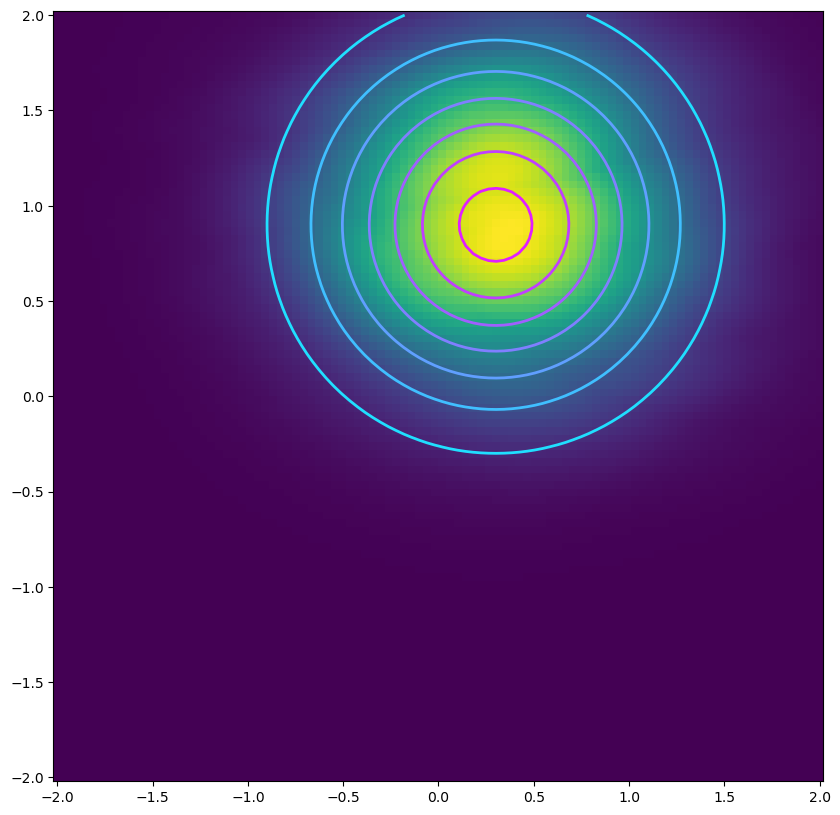

In [166]:
# Plot trained flow distribution, target as contours
model.eval()
log_prob = model.log_prob(zz, context_plot).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

## SAME WITH OTHER DATA

In [91]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 64, 64, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)

In [92]:
model = model.to(device)

In [93]:
# Define target distribution
target = nf.distributions.TwoMoons()

/data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1650973827143/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_66/453332150.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')


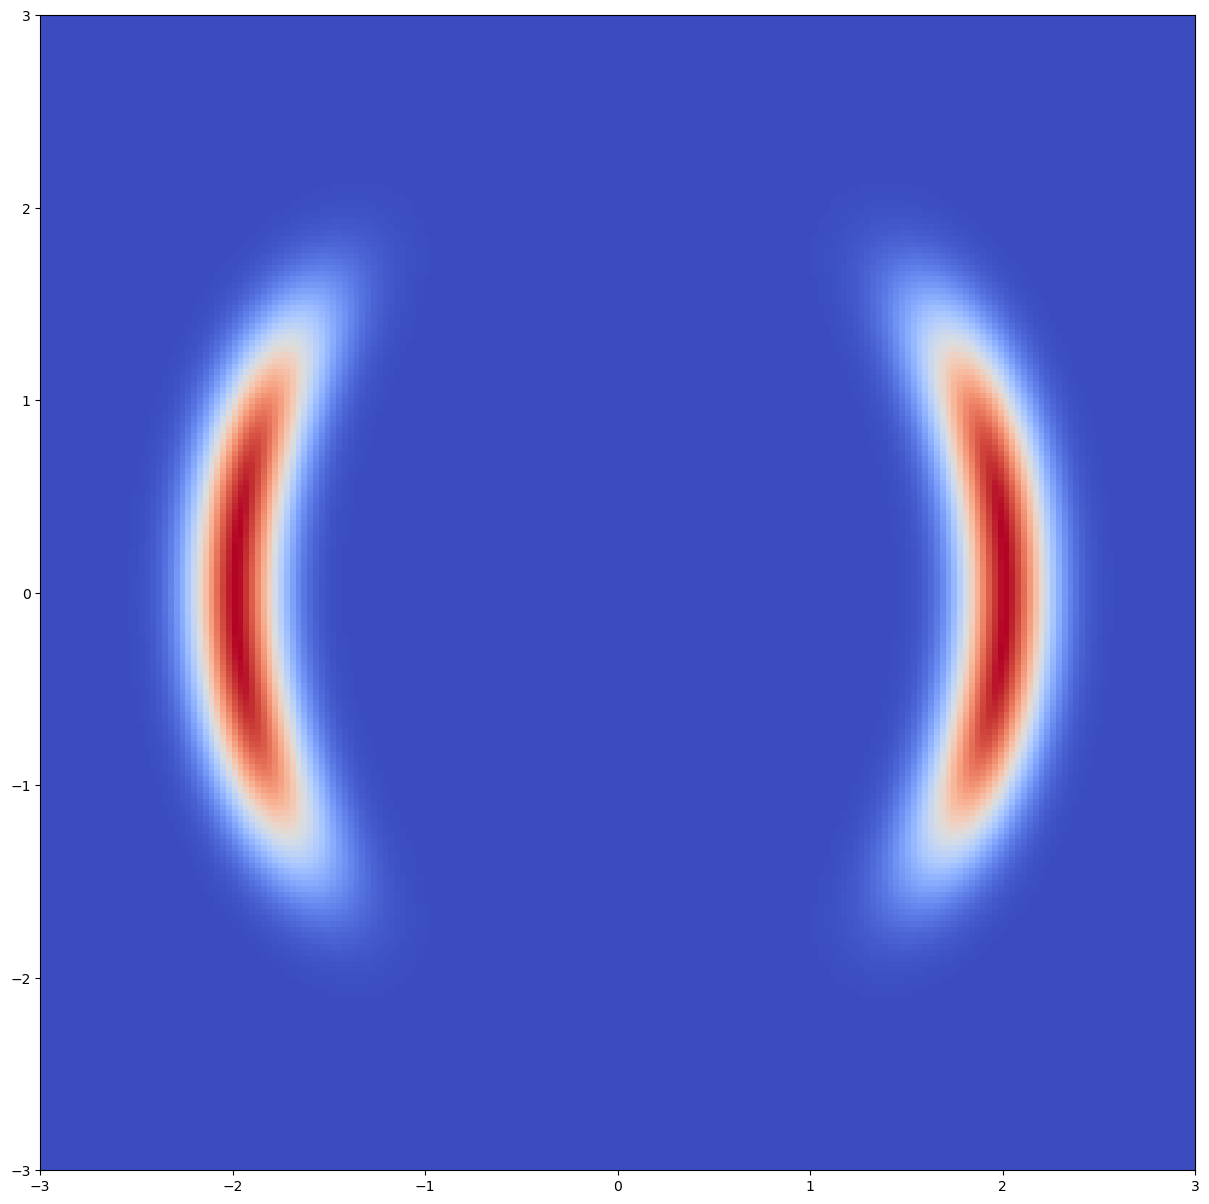

In [94]:
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

/tmp/ipykernel_66/3929658094.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')


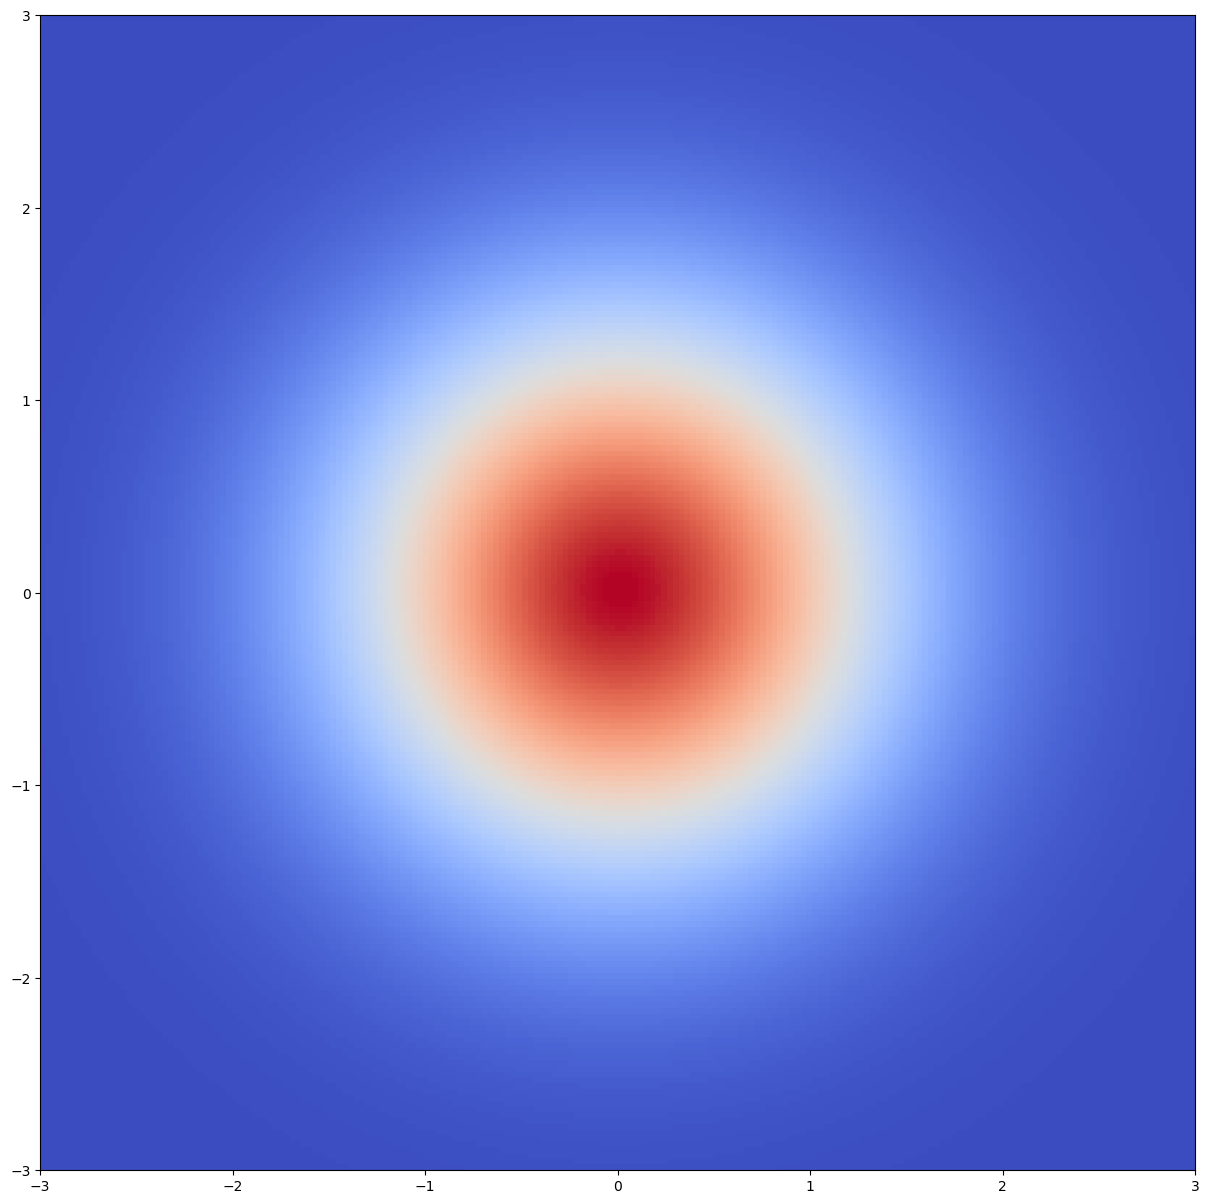

In [95]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

 12%|█▏        | 499/4000 [00:38<04:10, 13.95it/s]/tmp/ipykernel_66/2851951940.py:37: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')


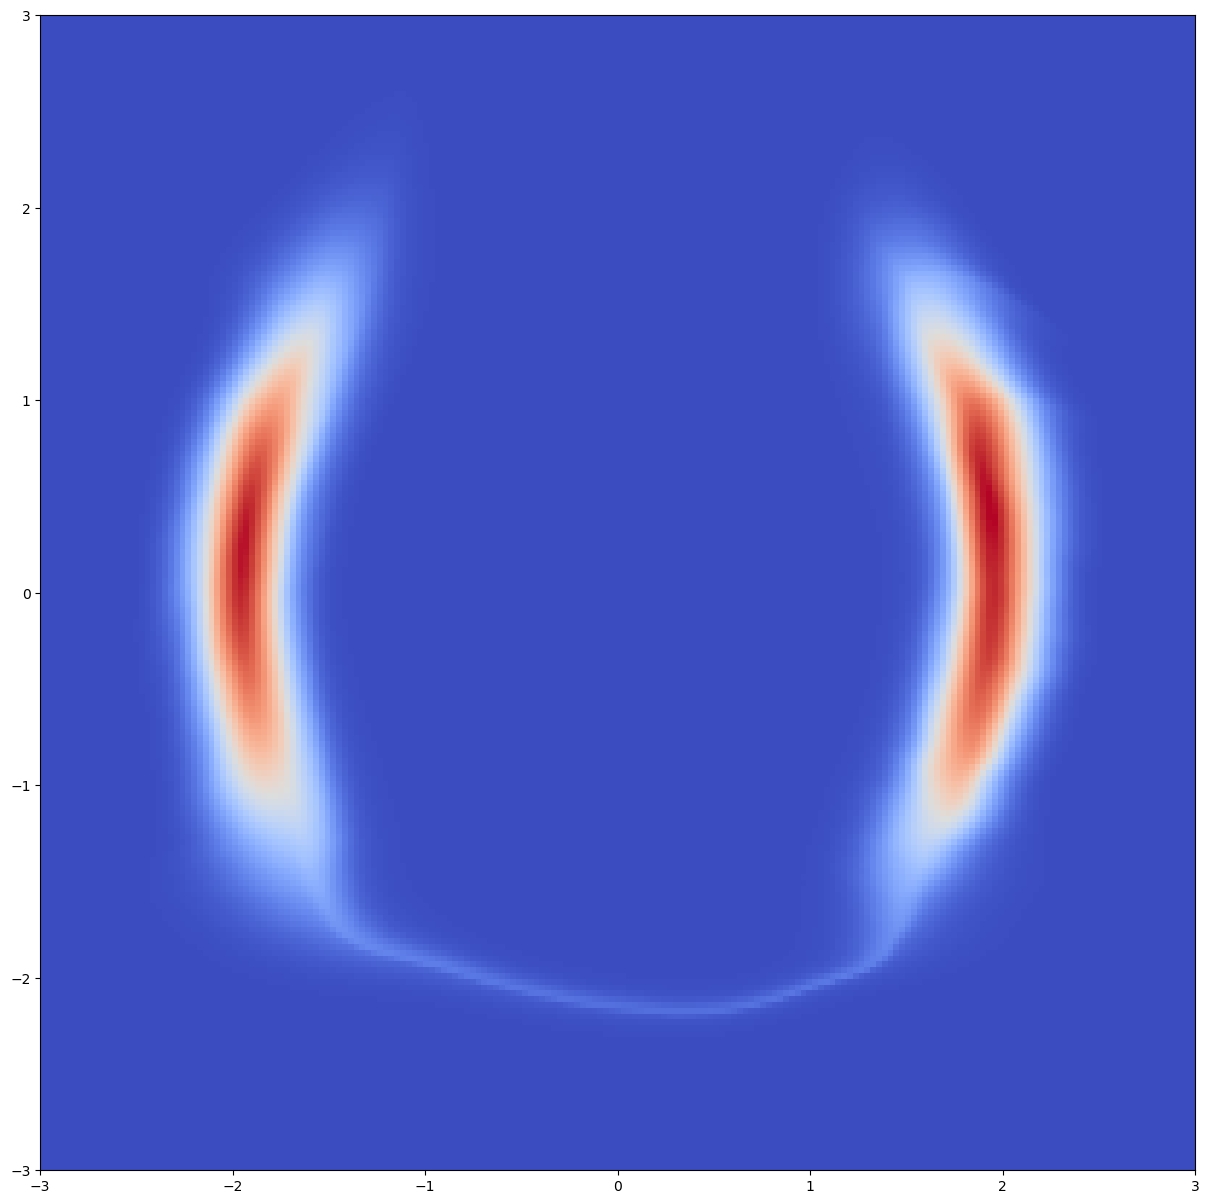

 25%|██▍       | 999/4000 [01:15<03:55, 12.74it/s]

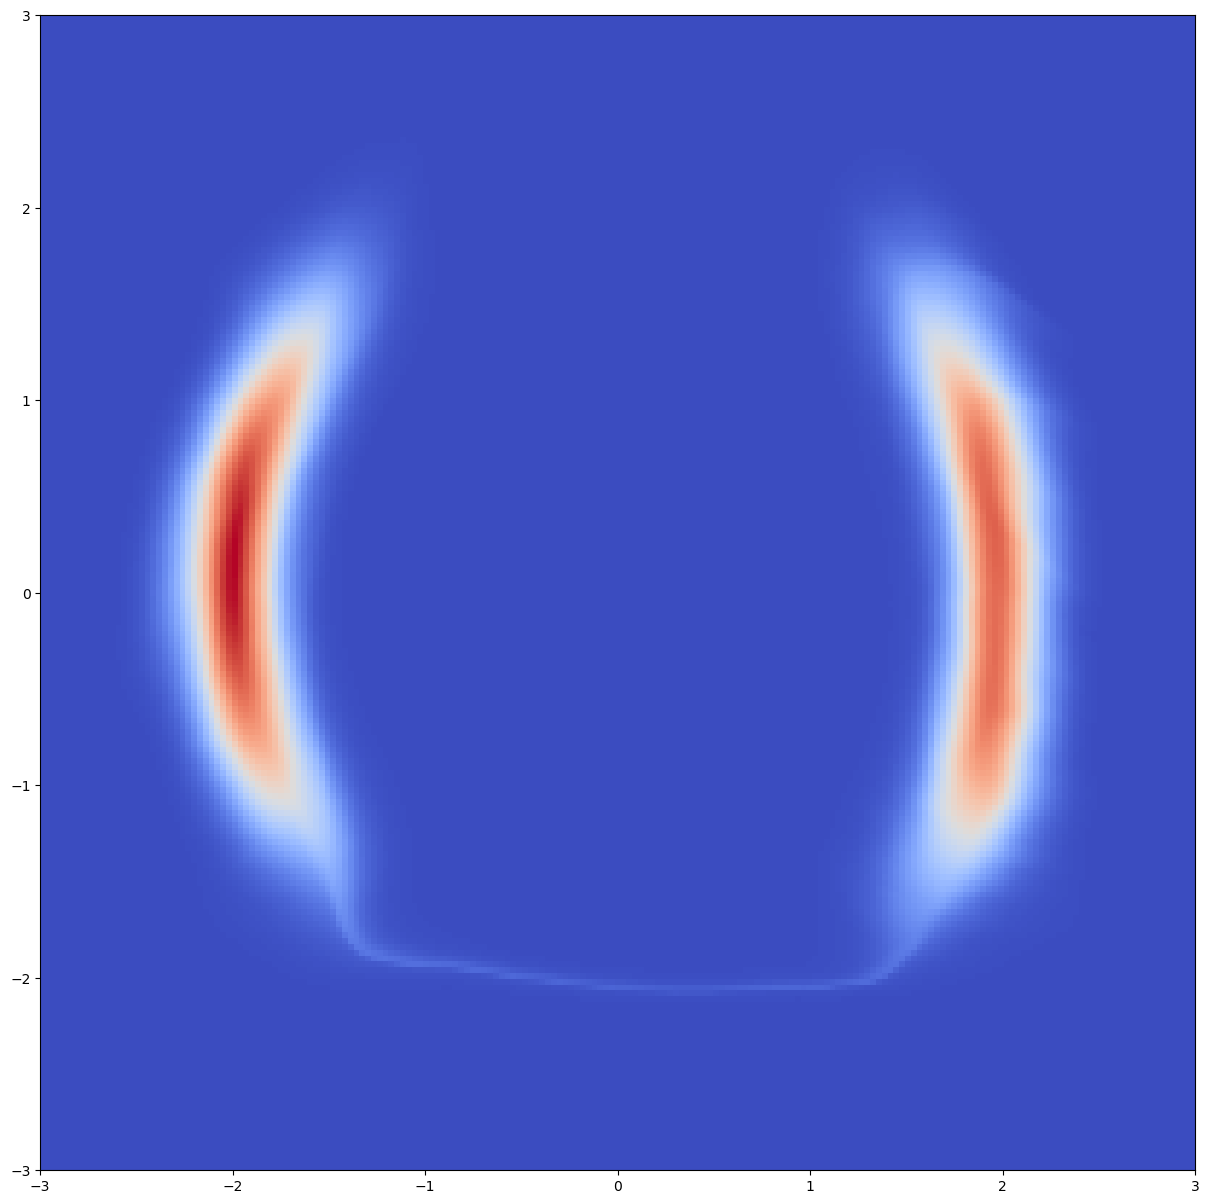

 37%|███▋      | 1499/4000 [01:51<03:06, 13.40it/s]

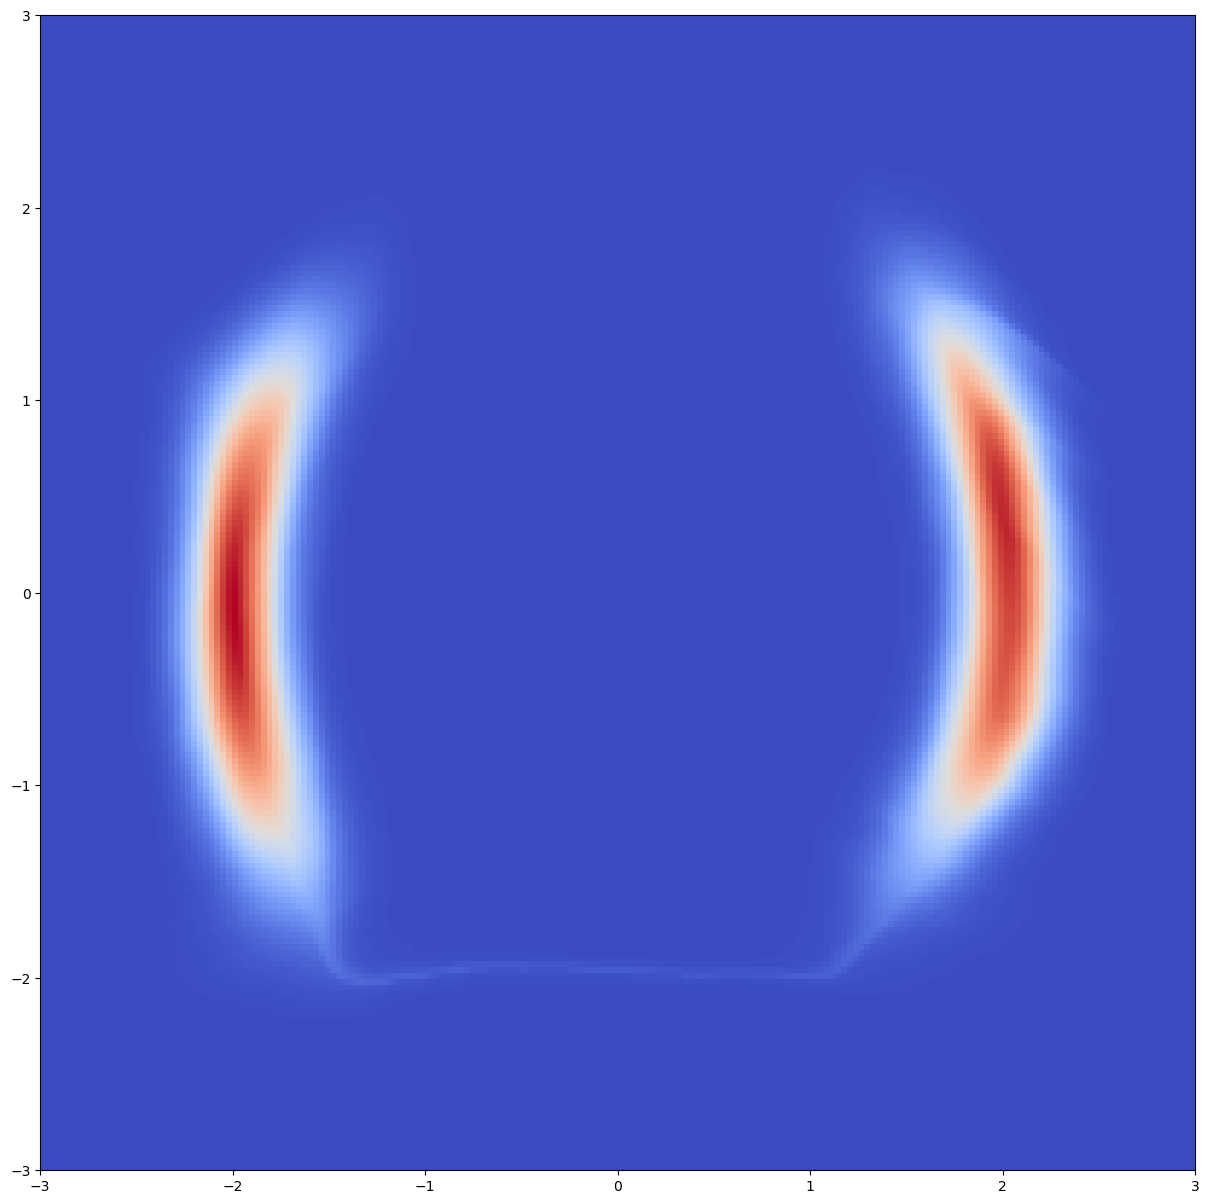

 50%|████▉     | 1999/4000 [02:29<02:34, 12.95it/s]

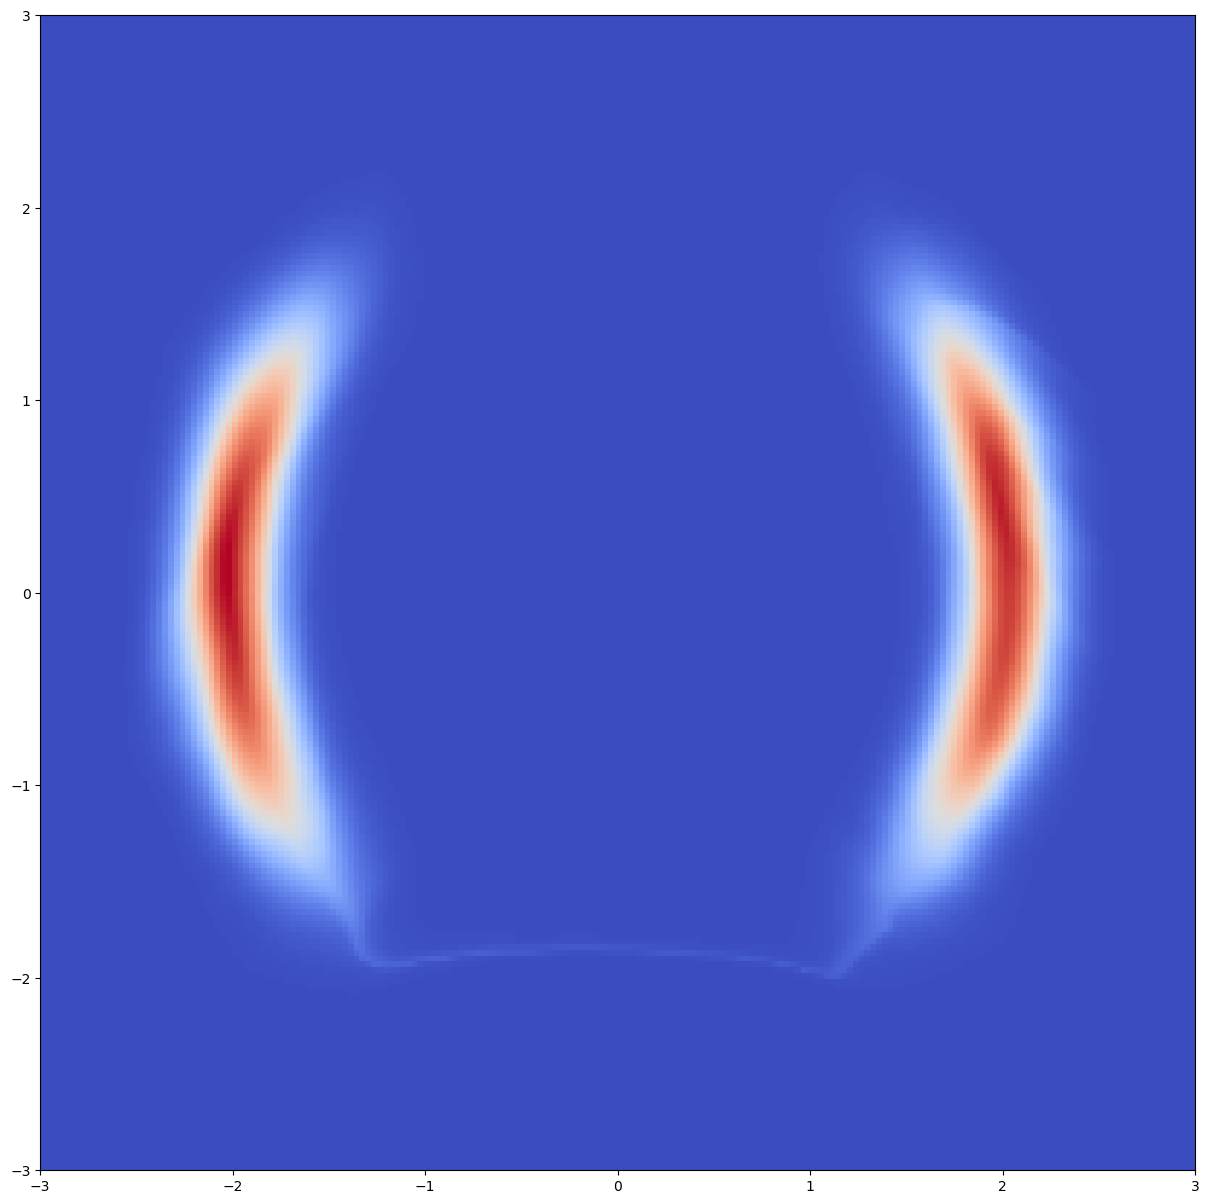

 62%|██████▏   | 2499/4000 [03:07<01:47, 14.01it/s]

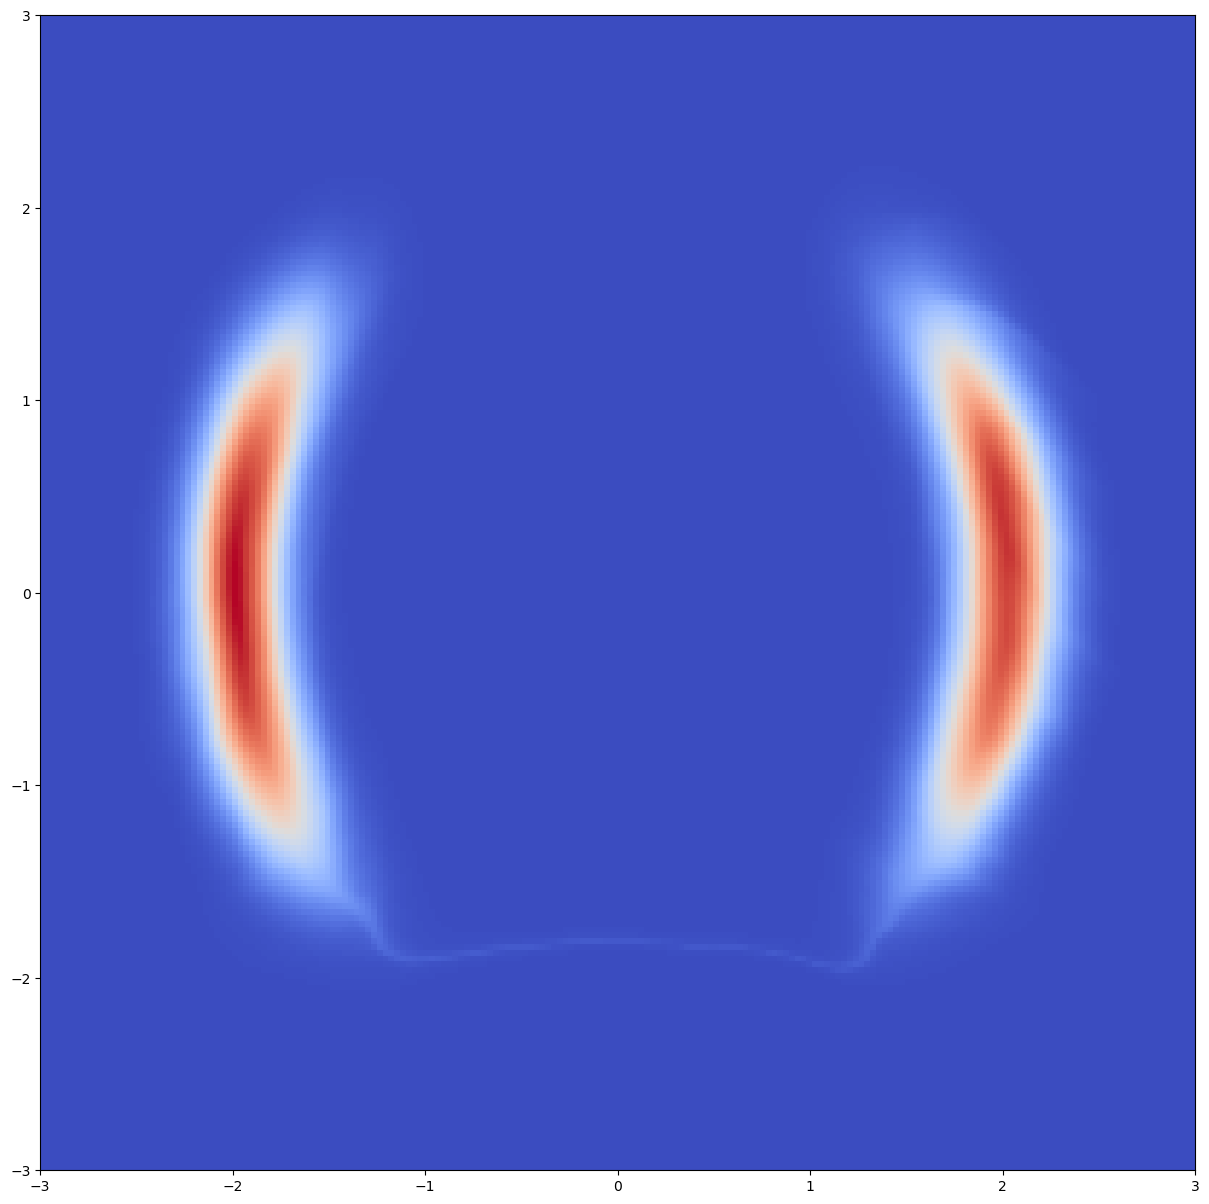

 75%|███████▍  | 2999/4000 [03:42<01:15, 13.34it/s]

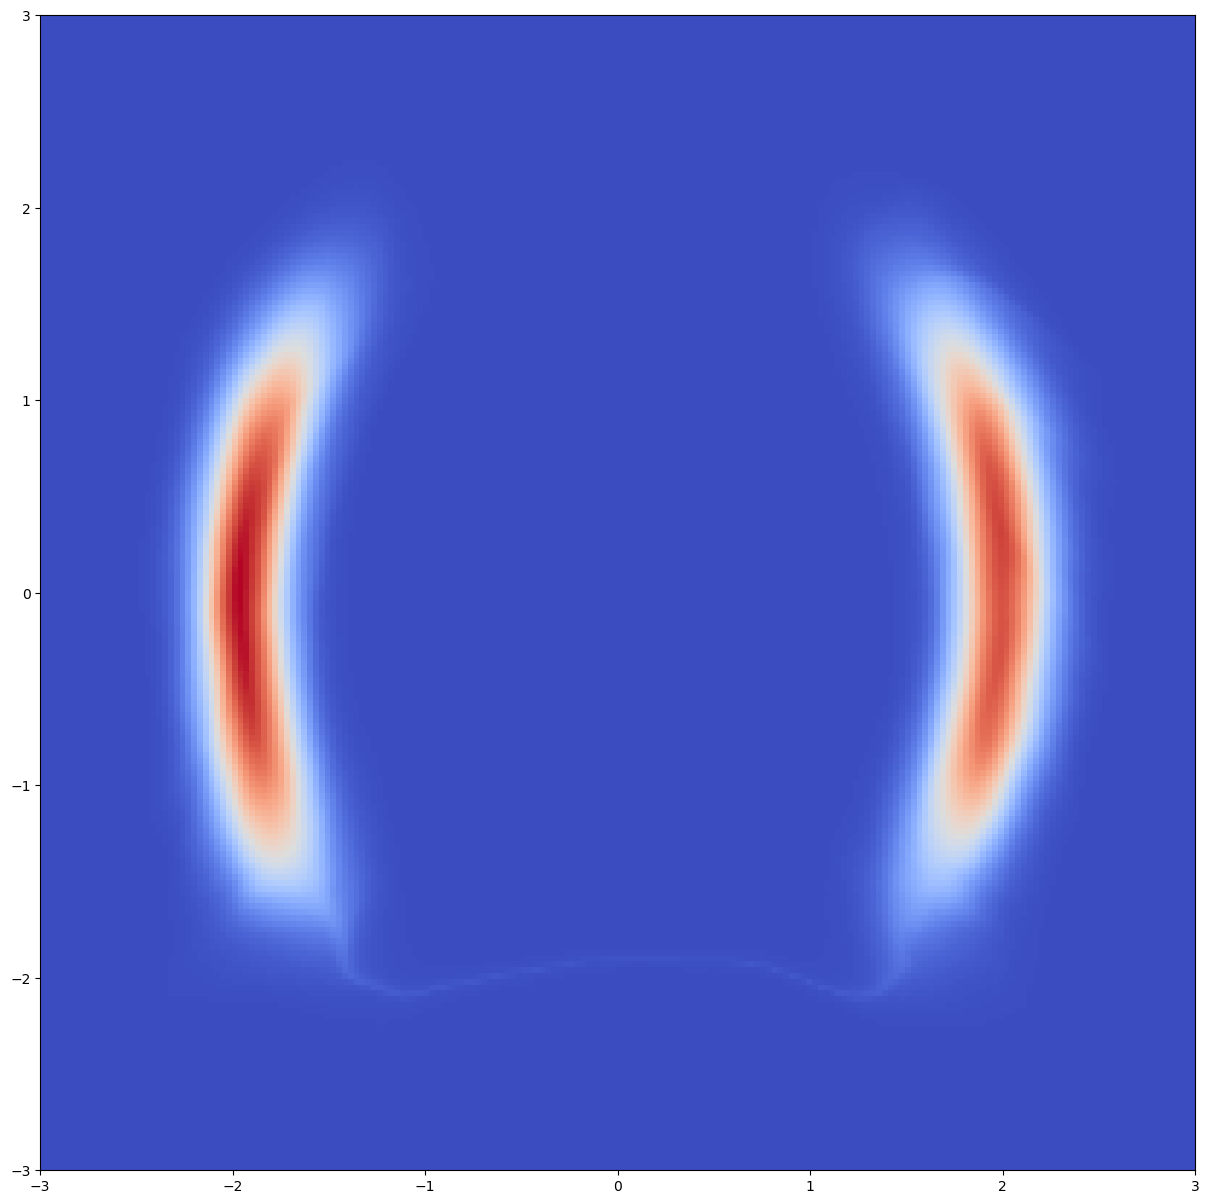

 87%|████████▋ | 3499/4000 [04:20<00:36, 13.63it/s]

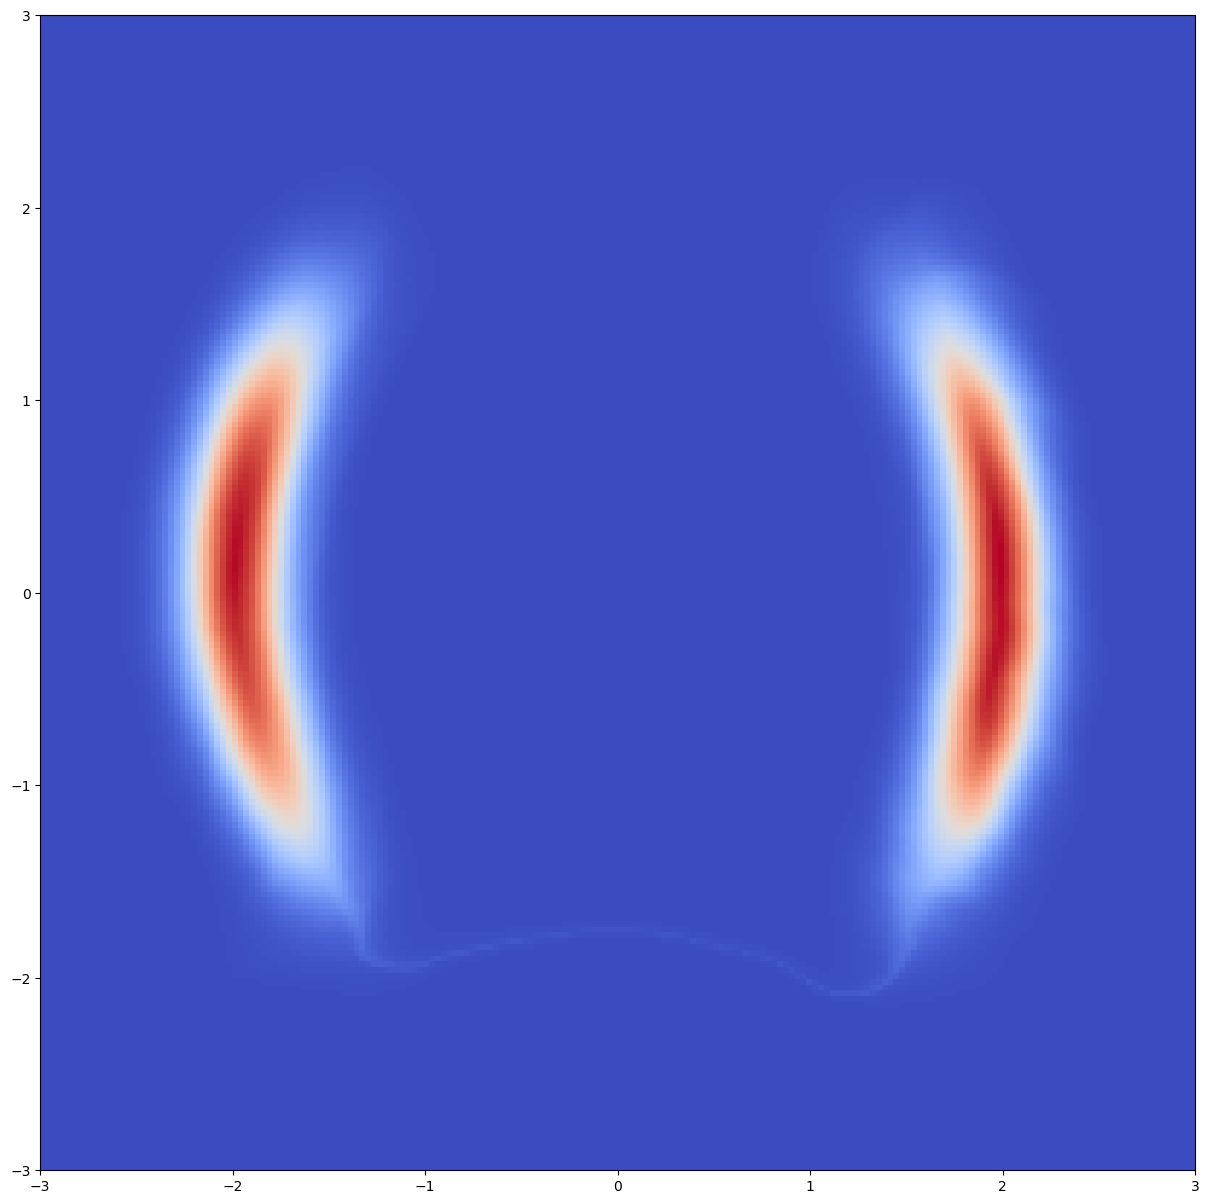

100%|█████████▉| 3999/4000 [04:58<00:00, 14.69it/s]

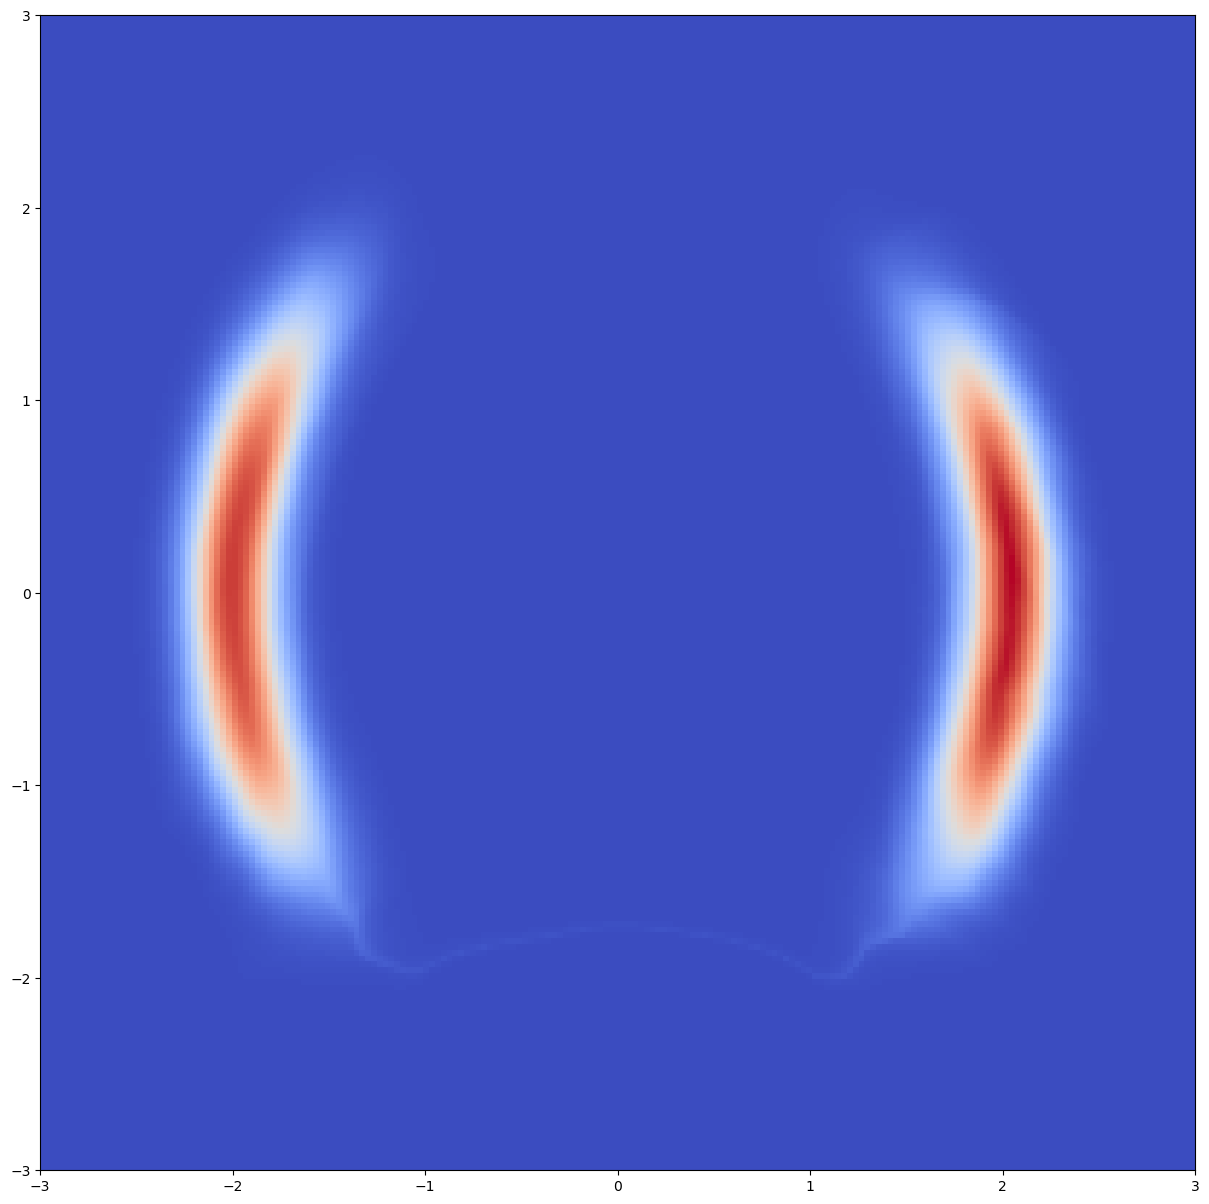

100%|██████████| 4000/4000 [04:58<00:00, 13.39it/s]


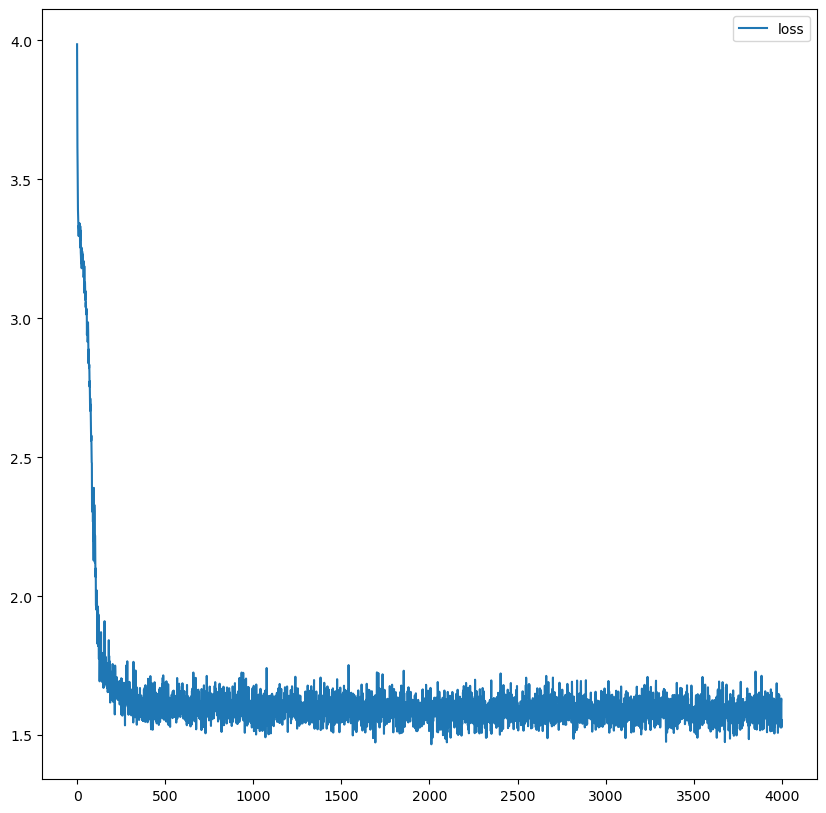

In [96]:
# Train model
max_iter = 4000
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    x = target.sample(num_samples).to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

/tmp/ipykernel_66/1680222339.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
/tmp/ipykernel_66/1680222339.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')


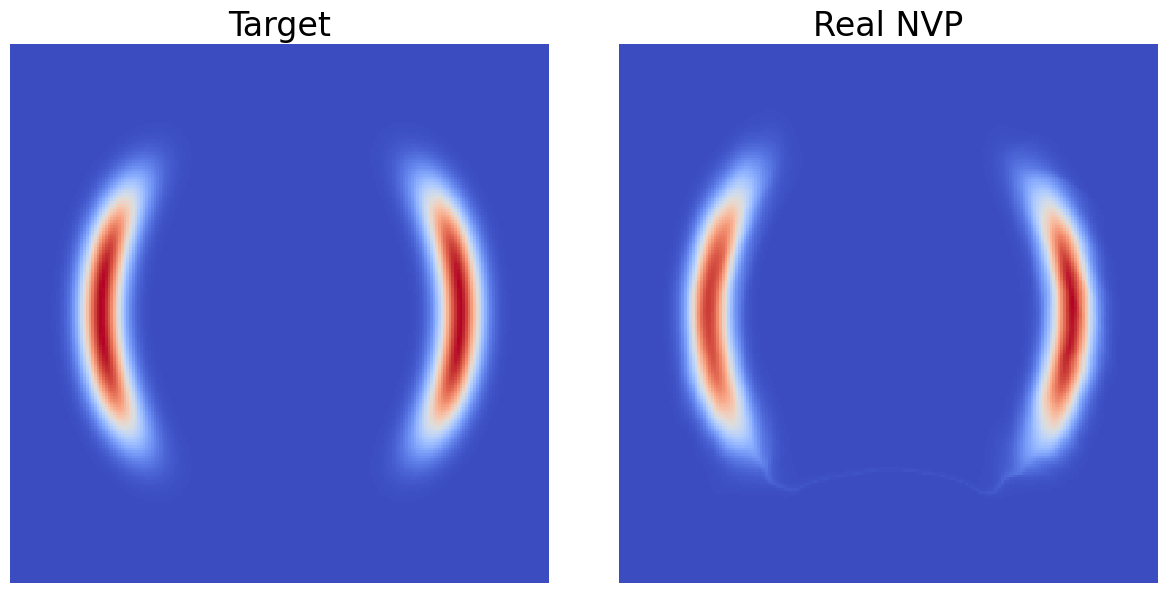

In [97]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('Target', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Real NVP', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

## ANOTHER EXAMPLE

In [111]:
class Conditinoal_Encoder(nn.Module):
    """Convolutional dense encoder for conditioning the generative model.
    See Fig. 4 of paper: https://arxiv.org/abs/2006.04731

    :param in_features: Number of input features
    :param enc_block_layers: list of the number of dense layers in each desired dense block
    :param init_features: Number of channels after te first convolution, defaults to 48
    :param output_features: Number of output channel features (will be twice this value
        since final value will be turned into mu and stds for latent variables), defaults to 8
    :type output_features: int, optional
    :param cond_features: Number of conditional feature channels, defaults to 8
    :type cond_features: int, optional
    :param cglow_upscale: The factor to upscale the features from the dense encode 
        before passing them to the generative model, defaults to 1
    :type cglow_upscale: int, optional
    :param bn_size: number of features after bottleneck if enabled, defaults to 8
    :type bn_size: int, optional
    :param drop_rate: Dropout rate, defaults to 0.
    :type drop_rate: float, optional
    """
    def __init__(self, init_features, 
                enc_block_layers, 
                hidden_features,
                output_dim=8, 
                drop_rate=0
                ):
        """Constructor method""" 
        super(Conditinoal_Encoder, self).__init__()
        # First encoding module

        self.encoding_blocks = []

        # Construct dense block layers
        num_feat = init_features
        for i in range(enc_block_layers):
            block = nn.Sequential()
            block.add_module('encode_mlp{}'.format(i), self.mlp_block(num_feat, hidden_features[i], drop_rate=drop_rate))
            num_feat = hidden_features[i]

            self.encoding_blocks.append(block)
            
        
        block.add_module('encode_mlp{}'.format(i+1),
            self.mlp_block(num_feat, 2*output_dim, drop_rate=drop_rate))
        
        # Convert lists to module lists
        self.encoding_blocks = nn.ModuleList(self.encoding_blocks)
        
    def mlp_block(self, in_features, out_features, drop_rate=0):
        """Encoding transition convolution placed between dense blocks, halves feature map size

        :param in_features: Number of input features
        :param output_features: Number of output features
        :param drop_rate: Dropout rate, defaults to 0.
        
        
            - encoder_trans: Transition PyTorch module
        :rtype: nn.Module
        """
        block = nn.Sequential(nn.Linear(in_features, out_features))
        block.add_module('linear1', nn.Linear(in_features, out_features))
        block.add_module('relu1', nn.ReLU(inplace=False))
        if drop_rate > 0:
            block.add_module('dropout1', nn.Dropout(p=drop_rate))

        return block

    def forward(self, x):
        """Encoder forward pass

        :param x: [B, in_features, H, W] input feature tensor
        :type x: torch.Tensor
        :returns:
            - out: Final encoder output
            - c_out: List of conditional output states to conditional the generative model
        :rtype: (torch.Tensor, list)
        """

        c_out = []
        for i, block in enumerate(self.encoding_blocks):
            # Pass though dense block
            dense_out = block(x)
            c_out.append(dense_out)
            out = dense_out
        return out, c_out


In [112]:
Conditinoal_Encoder(init_features=6, 
                enc_block_layers=3, 
                hidden_features = [10,50,10],
                output_dim=1, 
                drop_rate=0.1)

Conditinoal_Encoder(
  (encoding_blocks): ModuleList(
    (0): Sequential(
      (encode_mlp0): Sequential(
        (0): Linear(in_features=6, out_features=10, bias=True)
        (linear1): Linear(in_features=6, out_features=10, bias=True)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
      )
    )
    (1): Sequential(
      (encode_mlp1): Sequential(
        (0): Linear(in_features=10, out_features=50, bias=True)
        (linear1): Linear(in_features=10, out_features=50, bias=True)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
      )
    )
    (2): Sequential(
      (encode_mlp2): Sequential(
        (0): Linear(in_features=50, out_features=10, bias=True)
        (linear1): Linear(in_features=50, out_features=10, bias=True)
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
      )
      (encode_mlp3): Sequential(
        (0): Linear(in_features=10, out_features=2, bias=True)
        (linear1): Linear(in_f

In [ ]:

class AffineCouplingLayer(nn.Module):
    """Conditional invertable affine coupling layer.
    See Fig. 7 of paper: https://arxiv.org/abs/2006.04731

    :param in_features: Number of input feature channels
    :type in_features: int
    :param cond_features: Number of conditional feature channels
    :type cond_features: int

    :note: For more information see "NICE: Non-linear Independent 
        Components Estimation" by Dihn et al. https://arxiv.org/abs/1410.8516

    :note: Check Feistel cipher as this functions very similarly.
    """
    def __init__(self, in_features, cond_features):
        """Constructor method
        """ 
        super(AffineCouplingLayer, self).__init__()
        # assert in_features % 2 == 0, '# input features must be evenly split,'\
        #     'but got {} features'.format(in_features)
        if in_features % 2 == 0:
            in_channels = in_features // 2 + cond_features
            out_channels = in_features
        else:
            # chunk is be (2, 1) if in_features==3
            in_channels = in_features // 2 + 1 + cond_features
            out_channels = in_features - 1
        
        # Initialize coupling network (Dense Block)
        num_layers = 2
        growth_rate = 1
        self.coupling_nn = nn.Sequential()
        self.coupling_nn.add_module('dense_block', NoNormDenseBlock(num_layers, in_channels, 
                    growth_rate=growth_rate, drop_rate=0., bottleneck=False))
        self.coupling_nn.add_module('relu1', nn.ReLU(inplace=True))
        self.coupling_nn.add_module('zero_conv', Conv2dZeros(in_channels + growth_rate*num_layers, out_channels))

        self.softsign = nn.Softsign()

    def forward(self, x, cond):
        """Forward pass

        :param x:  [B, in_features, H, W] input feature tensor
        :type x: torch.Tensor
        :param cond: [B, cond_features, H, W] input feature tensor
        :type cond: torch.Tensor
        :returns: 
            - y: [B, in_features, H, W] Output feature tensor
            - logdet: log determinate of affine layer
        :rtype: (torch.Tensor, torch.Tensor)
        """
        #  Split in the channel dimension
        # last chunk is smaller if not odd number of channels
        x1, x2 = x.chunk(2, 1)
        h = self.coupling_nn(torch.cat((x1, cond), 1))

        shift = h[:, 0::2]
        scale = (2*self.softsign(h[:, 1::2])).exp()

        x2 = x2 + shift
        x2 = x2 * scale
        logdet = torch.abs(scale).log().view(x.shape[0], -1).sum(1)

        return torch.cat((x1, x2), 1), logdet

    def reverse(self, y, cond):
        """Backward pass

        :param y:  [B, in_features, H, W] input feature tensor
        :type y: torch.Tensor
        :param cond: [B, cond_features, H, W] input feature tensor
        :type cond: torch.Tensor
        :returns: 
            - x: [B, in_features, H, W] Output feature tensor
            - logdet: log determinate of affine layer
        :rtype: (torch.Tensor, torch.Tensor)
        """
        #  Split in the channel dimension
        y1, y2 = y.chunk(2, 1)

        h = self.coupling_nn(torch.cat((y1, cond), 1))

        shift = h[:, 0::2]
        scale = (2*self.softsign(h[:, 1::2])).exp()

        y2 = y2 / scale
        y2 = y2 - shift
        logdet = torch.abs(scale).log().view(y.shape[0], -1).sum(1)

        return torch.cat((y1, y2), 1), logdet

In [ ]:
'''
=====
Distributed by: Notre Dame SCAI Lab (MIT Liscense)
- Associated publication:
url: http://aimsciences.org//article/id/3a9f3d14-3421-4947-a45f-a9cc74edd097
doi: https://dx.doi.org/10.3934/fods.2020019
github: https://github.com/zabaras/deep-turbulence
=====
'''
import sys
sys.path.append(".")

from nn.modules.denseBlock import DenseBlock, NoNormDenseBlock
from nn.modules.convLSTM import ResidLSTMBlock
from nn.modules.flowUtils import Conv2dZeros
import torch
import torch.nn as nn
import torch.nn.functional as F

class AffineCouplingLayer(nn.Module):
    """Conditional invertable affine coupling layer.
    See Fig. 7 of paper: https://arxiv.org/abs/2006.04731

    :param in_features: Number of input feature channels
    :type in_features: int
    :param cond_features: Number of conditional feature channels
    :type cond_features: int

    :note: For more information see "NICE: Non-linear Independent 
        Components Estimation" by Dihn et al. https://arxiv.org/abs/1410.8516

    :note: Check Feistel cipher as this functions very similarly.
    """
    def __init__(self, in_features, cond_features):
        """Constructor method
        """ 
        super(AffineCouplingLayer, self).__init__()
        # assert in_features % 2 == 0, '# input features must be evenly split,'\
        #     'but got {} features'.format(in_features)
        if in_features % 2 == 0:
            in_channels = in_features // 2 + cond_features
            out_channels = in_features
        else:
            # chunk is be (2, 1) if in_features==3
            in_channels = in_features // 2 + 1 + cond_features
            out_channels = in_features - 1
        
        # Initialize coupling network (Dense Block)
        num_layers = 2
        growth_rate = 1
        self.coupling_nn = nn.Sequential()
        self.coupling_nn.add_module('dense_block', NoNormDenseBlock(num_layers, in_channels, 
                    growth_rate=growth_rate, drop_rate=0., bottleneck=False))
        self.coupling_nn.add_module('relu1', nn.ReLU(inplace=True))
        self.coupling_nn.add_module('zero_conv', Conv2dZeros(in_channels + growth_rate*num_layers, out_channels))

        self.softsign = nn.Softsign()

    def forward(self, x, cond):
        """Forward pass

        :param x:  [B, in_features, H, W] input feature tensor
        :type x: torch.Tensor
        :param cond: [B, cond_features, H, W] input feature tensor
        :type cond: torch.Tensor
        :returns: 
            - y: [B, in_features, H, W] Output feature tensor
            - logdet: log determinate of affine layer
        :rtype: (torch.Tensor, torch.Tensor)
        """
        #  Split in the channel dimension
        # last chunk is smaller if not odd number of channels
        x1, x2 = x.chunk(2, 1)
        h = self.coupling_nn(torch.cat((x1, cond), 1))

        shift = h[:, 0::2]
        scale = (2*self.softsign(h[:, 1::2])).exp()

        x2 = x2 + shift
        x2 = x2 * scale
        logdet = torch.abs(scale).log().view(x.shape[0], -1).sum(1)

        return torch.cat((x1, x2), 1), logdet

    def reverse(self, y, cond):
        """Backward pass

        :param y:  [B, in_features, H, W] input feature tensor
        :type y: torch.Tensor
        :param cond: [B, cond_features, H, W] input feature tensor
        :type cond: torch.Tensor
        :returns: 
            - x: [B, in_features, H, W] Output feature tensor
            - logdet: log determinate of affine layer
        :rtype: (torch.Tensor, torch.Tensor)
        """
        #  Split in the channel dimension
        y1, y2 = y.chunk(2, 1)

        h = self.coupling_nn(torch.cat((y1, cond), 1))

        shift = h[:, 0::2]
        scale = (2*self.softsign(h[:, 1::2])).exp()

        y2 = y2 / scale
        y2 = y2 - shift
        logdet = torch.abs(scale).log().view(y.shape[0], -1).sum(1)

        return torch.cat((y1, y2), 1), logdet

class LSTMAffineCouplingLayer(nn.Module):
    """Conditional LSTM invertable affine coupling layer.
    See Fig. 7 of paper: https://arxiv.org/abs/2006.04731

    :param in_features: Number of input feature channels
    :type in_features: int
    :param cond_features: Number of conditional feature channels
    :type cond_features: int
    :param rec_features: Number of recurrent feature channels, 
        output from :class:`nn.modules.convLSTM.ResidLSTMBlock`
    :type rec_features: int

    :note: For more information see "NICE: Non-linear Independent 
        Components Estimation" by Dihn et al. https://arxiv.org/abs/1410.8516

    :note: Check Feistel cipher as this functions very similarly.
    """
    def __init__(self, in_features, cond_features, rec_features):
        """Constructor method
        """ 
        super(LSTMAffineCouplingLayer, self).__init__()
        # assert in_features % 2 == 0, '# input features must be evenly split,'\
        #     'but got {} features'.format(in_features)
        if in_features % 2 == 0:
            in_channels = in_features // 2 + cond_features
            out_channels = in_features
        else:
            # chunk is be (2, 1) if in_features==3
            in_channels = in_features // 2 + 1 + cond_features
            out_channels = in_features - 1
        
        # Initialize coupling network (Dense Block)
        num_layers = 2
        growth_rate = 1

        # LSTM block
        self.resid_lstm = ResidLSTMBlock(in_channels, rec_features, in_channels, kernel_size=(3,3))

        self.dense_nn = nn.Sequential()
        self.dense_nn.add_module('dense_block', NoNormDenseBlock(num_layers, in_channels,
                    growth_rate=growth_rate, drop_rate=0., bottleneck=False))
        self.dense_nn.add_module('relu1', nn.ReLU(inplace=True))

        # Output convolution
        num_feat = in_channels + growth_rate*num_layers
        self.out_conv = nn.Sequential()
        self.out_conv.add_module('zero_conv', Conv2dZeros(num_feat, out_channels))

        self.softsign = nn.Softsign()

    def forward(self, x, cond, rec_states=None):
        """Forward pass

        :param x:  [B, in_features, H, W] input feature tensor
        :type x: torch.Tensor
        :param cond: [B, cond_features, H, W] input feature tensor
        :type cond: torch.Tensor
        :param rec_states: tuple of LSTM states (hidden state, cell state), defaults to None
        :type rec_states: tuple, optional
        :returns: 
            - y: [B, in_features, H, W] Output feature tensor
            - logdet: log determinate of affine layer
            - states_out: tuple of LSTM (cell, hidden) states
        :rtype: (torch.Tensor, torch.Tensor, tuple)
        """
        #  Split in the channel dimension
        x1, x2 = x.chunk(2, 1)

        if(rec_states is None):
            out, h_next, c_next = self.resid_lstm(torch.cat((x1, cond), 1), None)
            # Store lstm states for next time-step and flow conditions
            states_out = (h_next, c_next)
        else:
            
            out, h_next, c_next = self.resid_lstm(torch.cat((x1, cond), 1), rec_states)
            # Store lstm states for next time-step and flow conditions
            states_out = (h_next, c_next)

        out = self.dense_nn(out)
        h = self.out_conv(out)
        shift = h[:, 0::2]
        scale = (2*self.softsign(h[:, 1::2])).exp()

        x2 = x2 + shift
        x2 = x2 * scale
        logdet = torch.abs(scale).log().view(x.shape[0], -1).sum(1)

        return torch.cat((x1, x2), 1), logdet, states_out

    def reverse(self, y, cond, rec_states=None):
        """Backward pass

        :param y:  [B, in_features, H, W] input feature tensor
        :type y: torch.Tensor
        :param cond: [B, in_features, H, W] input feature tensor
        :type cond: torch.Tensor
        :param rec_states: tuple of LSTM states (hidden state, cell state), defaults to None
        :type rec_states: tuple, optional
        :returns: 
            - x: [B, in_features, H, W] Output feature tensor
            - logdet: log determinate of affine layer
            - states_out: tuple of LSTM (cell, hidden) states
        :rtype: (torch.Tensor, torch.Tensor, tuple)
        """
        #  Split in the channel dimension
        y1, y2 = y.chunk(2, 1)

        if(rec_states is None):
            out, h_next, c_next = self.resid_lstm(torch.cat((y1, cond), 1), None)
            # Store lstm states for next time-step and flow conditions
            states_out = (h_next, c_next)
        else:
            out, h_next, c_next = self.resid_lstm(torch.cat((y1, cond), 1), rec_states)
            # Store lstm states for next time-step and flow conditions
            states_out = (h_next, c_next)

        out = self.dense_nn(out)
        h = self.out_conv(out)
        shift = h[:, 0::2]
        scale = (2*self.softsign(h[:, 1::2])).exp()

        y2 = y2 / scale
        y2 = y2 - shift
        logdet = torch.abs(scale).log().view(y.shape[0], -1).sum(1)

        return torch.cat((y1, y2), 1), logdet, states_out

In [59]:
import torch.utils.data as data

In [60]:
class half_circle(data.Dataset):
    r'''Generate a dataset of points on a half circle.'''
    def __init__(self, n=512):
        super(half_circle, self).__init__()
        self.n = n
    
    def __getitem__(self, index):
        r = 1.0
        phi = torch.rand(1) * torch.pi
        x = torch.cos(phi) * r
        y = torch.sin(phi) * r
        return torch.cat((x, y), 0) + torch.randn(2) / 20
    
    def __len__(self):
        return self.n

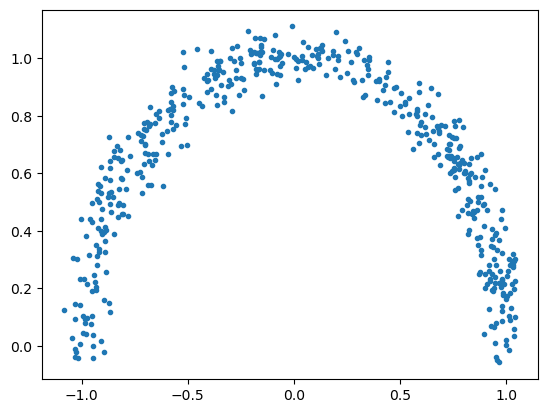

In [61]:
sampled = np.array([half_circle()[0].tolist() for i in range(500)])
plt.plot(sampled[:,0], sampled[:,1], '.')
plt.show()

In [62]:
trainingdata = data.DataLoader(half_circle(n=1000), batch_size=64)

In [81]:
num_layers = 3
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1, 512, 512, 512, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(num_layers, mode='swap'))

In [82]:
target_dist = nf.distributions.DiagGaussian(1)

In [70]:
model = nf.NormalizingFlow(target_dist, flows)

In [75]:
model.forward_and_log_det?

Signature: model.forward_and_log_det(z)
Docstring:
Transforms latent variable z to the flow variable x and
computes log determinant of the Jacobian

Args:
  z: Batch in the latent space

Returns:
  Batch in the space of the target distribution,
  log determinant of the Jacobian
File:      /data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/normflows/core.py
Type:      method

In [83]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [84]:
model.forward_and_log_det?

Signature: model.forward_and_log_det(z)
Docstring:
Transforms latent variable z to the flow variable x and
computes log determinant of the Jacobian

Args:
  z: Batch in the latent space

Returns:
  Batch in the space of the target distribution,
  log determinant of the Jacobian
File:      /data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/normflows/core.py
Type:      method

In [86]:
loss_count = []
for i in range(50):
    losses = []
    for x in trainingdata:
        optimizer.zero_grad()
        loss = model.forward_and_log_det(x)
        py = base.logp(y)
        assert False

        loss = py + logp + logdet
        loss = -1 * loss.mean()

        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    loss_count.append(np.mean(losses))
    print(sum(losses) / len(losses))

ValueError: not enough values to unpack (expected 2, got 1)

In [49]:
Nclass = 10000
xs = np.random.uniform(0,10,Nclass)
Nsamp = 10

training_sample = torch.zeros(size =(Nclass, Nsamp))
label = torch.zeros(size =(Nclass, 2))

for ii,x in enumerate(xs):
    xsamp = 0.1*torch.randn(1,Nsamp)+x
    training_sample[ii] = xsamp
    label[ii] = x
    
    

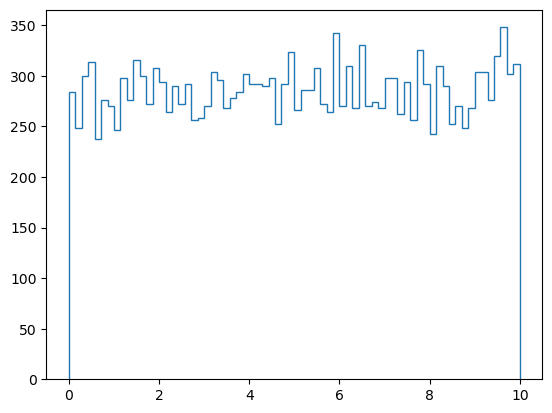

In [53]:
plt.hist(label.detach().cpu().numpy().flatten(), bins=70, histtype='step')
plt.show()

In [56]:
target_dist = nf.distributions.DiagGaussian(1)

In [38]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 10

zz = label.clone()
zz = zz.to(device)
context_plot = training_sample.clone().to(device)

logp = target.log_prob(zz, context_plot)
assert False
p_target = torch.exp(logp).view(*xx.shape).cpu().data.numpy()

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, p_target, shading='auto')
plt.gca().set_aspect('equal', 'box')
plt.show()

RuntimeError: The size of tensor a (2) must match the size of tensor b (8) at non-singleton dimension 1

In [ ]:
# Train model
max_iter = 5000
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    context = torch.cat([torch.randn((batch_size, 2), device=device), 
                         0.5 + 0.5 * torch.rand((batch_size, 2), device=device)], 
                        dim=-1)
    x = target.sample(batch_size, context)
    
    # Compute loss
    loss = model.forward_kld(x, context)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

## CREATE DATA

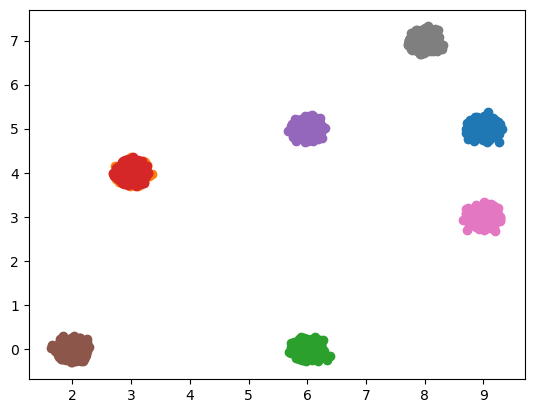

In [117]:
xs, ys = np.random.randint(0,10,8),np.random.randint(0,10,8)

Nclass = 8
Nsamp = 1000
training_sample = torch.zeros(size =(Nclass, Nsamp, 8))
label = torch.zeros(size =(Nclass, Nsamp, 8))
for ii,(x,y) in enumerate(zip(xs,ys)):
    xsamp, ysamp = 0.1*torch.randn(Nsamp,1)+x, 0.1*torch.randn(Nsamp,1)+y
    training_sample[ii,:,:2] = torch.concat((xsamp,ysamp),1)
    training_sample[ii,:,2:] =  training_sample[ii,:,2:] + 0.05*torch.randn(Nsamp,6)
    label[ii,:,ii] = 1
    
    plt.scatter(xsamp,ysamp)
    
plt.show()

In [118]:
training_sample = training_sample.reshape(Nsamp*Nclass,2)
label = label.reshape(Nsamp*Nclass,8)

RuntimeError: shape '[8000, 2]' is invalid for input of size 64000

dset = TensorDataset(training_sample,label)
from torch.utils.data import random_split
dset_train, dset_val = random_split(dset, [int(0.9*len(dset)), int(0.1*len(dset))])

loader = DataLoader(dset_train, batch_size=100, shuffle=True)
loader_val = DataLoader(dset_val, batch_size=100, shuffle=False)

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## NORMALIZING FLOW

# Define list of flows
num_layers = 8
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 32 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([4, 512, 512, 512, 2], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(num_layers, mode='swap'))

model = nf.NormalizingFlow(base, flows)

for x,y in loader:
    print(x.shape,y.shape)
    loss = model.forward_kld(y)

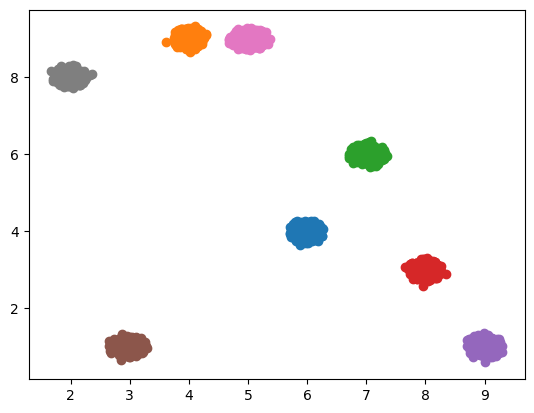

In [119]:
xs, ys = np.random.randint(0,10,8),np.random.randint(0,10,8)
Nclass = 8
Nsamp = 1000
training_sample = torch.zeros(size =(Nclass, Nsamp, 2))
label = torch.zeros(size =(Nclass, Nsamp, 8))
for ii,(x,y) in enumerate(zip(xs,ys)):
    xsamp, ysamp = 0.1*torch.randn(Nsamp,1)+x, 0.1*torch.randn(Nsamp,1)+y
    training_sample[ii] = torch.concat((xsamp,ysamp),1)
    #training_sample[ii,:,2:] =  training_sample[ii,:,2:] + 0.05*torch.randn(Nsamp,6)
    label[ii,:,ii] = 1
    
    plt.scatter(xsamp,ysamp)
    
plt.show()

In [120]:
training_sample = training_sample.reshape(Nsamp*Nclass,2)
label = label.reshape(Nsamp*Nclass,8)

In [136]:
dset = TensorDataset(training_sample,label)
from torch.utils.data import random_split
dset_train, dset_val = random_split(dset, [int(0.9*len(dset)), int(0.1*len(dset))])

loader = DataLoader(dset_train, batch_size=100, shuffle=True)
loader_val = DataLoader(dset_val, batch_size=100, shuffle=False)

In [135]:
# Define flows
K = 4

latent_size = 2
hidden_units = 512
hidden_layers = 3
context_size=8
flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units,
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(2, trainable=False)
    # Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

model = model.to(device)

In [122]:
# Define target
target = nf.distributions.target.ConditionalDiagGaussian()
context_size = 2


In [140]:
context.shape

torch.Size([128, 4])

In [146]:
xx.shape

torch.Size([128, 2])

In [144]:
label.shape

torch.Size([8000, 8])

In [147]:
x.shape

torch.Size([100, 2])

In [ ]:
loss = model.forward_kld(x, context)

In [151]:
target = nf.distributions.target.ConditionalDiagGaussian()

In [152]:
target.log_prob?

Signature: target.log_prob(z, context=None)
Docstring:
Args:
  z: value or batch of latent variable

Returns:
  log probability of the distribution for z
File:      /data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/normflows/distributions/target.py
Type:      method

In [158]:
context_plot = torch.cat([torch.tensor([0.3, 0.9]).to(device) + torch.zeros_like(zz), 
                          0.6 * torch.ones_like(zz)], dim=-1)

0
1
2
3
4
5
6
7
8
9


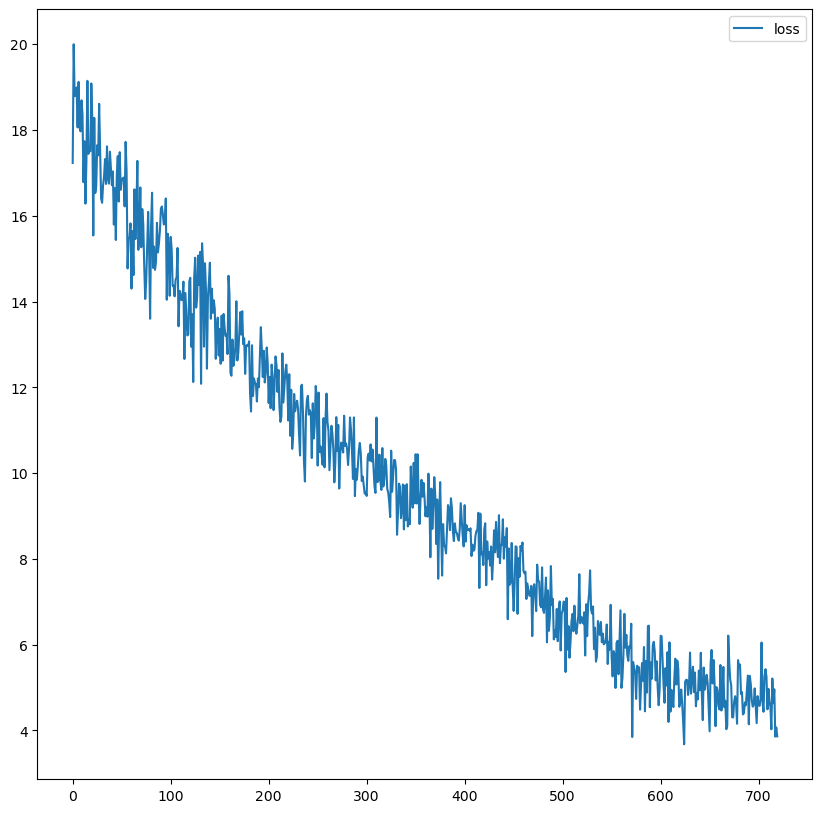

In [157]:
# Train model
max_iter = 10
batch_size= 128

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)


for it in range(max_iter):
    print(it)
    
    for x,y in loader:
        optimizer.zero_grad()
        loss = model.forward_kld(x.to(device), y.to(device))
        loss.backward()
        optimizer.step()
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [104]:
context_plot

tensor([[0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000],
        ...,
        [0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000],
        [0.3000, 0.9000, 0.6000, 0.6000]], device='cuda:0')

In [ ]:
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(10, 10))
plt.pcolormesh(xx, yy, prob.data.numpy(), shading='auto')
plt.contour(xx, yy, p_target, cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [73]:
base = nf.distributions.base.DiagGaussian(2)

In [79]:
model = nf.NormalizingFlow(base, flows)

In [82]:
for x,y in loader:
    print(x.shape,y.shape)
    loss = model.forward_kld(y)

torch.Size([100, 8]) torch.Size([100, 8])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x4 and 2x512)

In [17]:
target = nf.distributions.target.TwoMoons()

In [19]:
target?

Signature:      target(*input, **kwargs)
Type:           TwoMoons
String form:    TwoMoons()
File:           /data/astro/scratch/lcabayol/anaconda3/envs/DLenv2/lib/python3.9/site-packages/normflows/distributions/target.py
Docstring:      Bimodal two-dimensional distribution
Init docstring:
Constructor

Args:
  prop_scale: Scale for the uniform proposal
  prop_shift: Shift for the uniform proposal

In [ ]:
base_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2), torch.ones(2)), 
  1
)
target_dist = torch.distributions.Independent(
  torch.distributions.Normal(torch.zeros(2)+5, torch.ones(2)*0.5),
  1
)

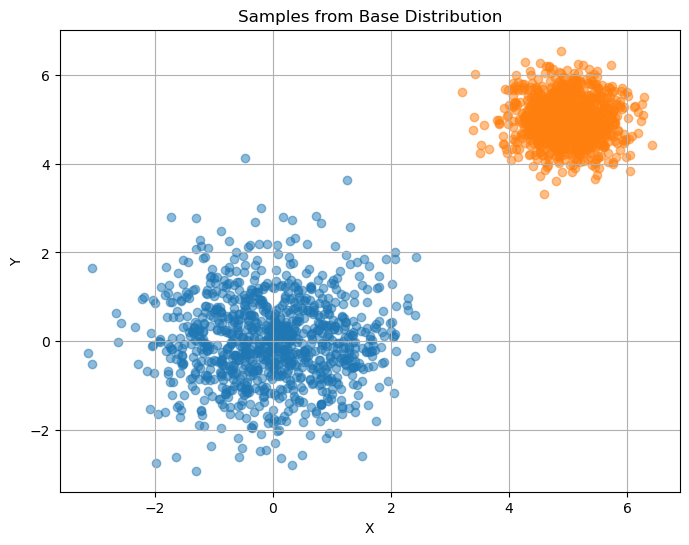

In [7]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

## CREATE NORMALIZING FLOW

##### Normalizing flow with a single transformation

In [8]:
bijectors = bij.AffineAutoregressive()

In [9]:
flow = dist.Flow(base_dist, bijectors)

In [10]:
# Training loop
opt = torch.optim.Adam(flow.parameters(), lr=5e-3)
for idx in range(3001):
    opt.zero_grad()

    # Minimize KL(p || q)
    y = target_dist.sample((1000,))
    loss = -flow.log_prob(y).mean()

    if idx % 500 == 0:
        print('epoch', idx, 'loss', loss)

    loss.backward()
    opt.step()

epoch 0 loss tensor(23.8129, grad_fn=<NegBackward0>)
epoch 500 loss tensor(3.6865, grad_fn=<NegBackward0>)
epoch 1000 loss tensor(3.2616, grad_fn=<NegBackward0>)
epoch 1500 loss tensor(3.0639, grad_fn=<NegBackward0>)
epoch 2000 loss tensor(2.5082, grad_fn=<NegBackward0>)
epoch 2500 loss tensor(1.6517, grad_fn=<NegBackward0>)
epoch 3000 loss tensor(1.4682, grad_fn=<NegBackward0>)


In [25]:
dist_y = dist.Flow(base_dist, bijectors)

In [28]:
num_samples = 1000
samples_pred = dist_y.sample((num_samples,))



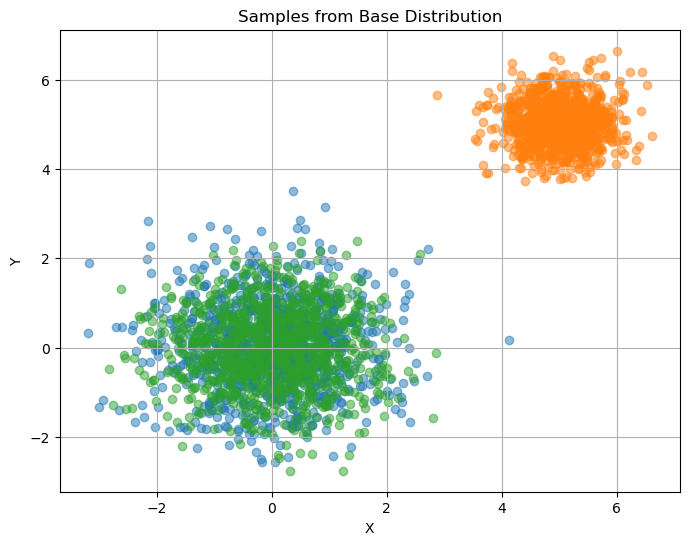

In [29]:
num_samples = 1000
samples_base = base_dist.sample((num_samples,))
samples_target = target_dist.sample((num_samples,))

# Extract x and y coordinates for plotting
x_values_base = samples_base[:, 0].numpy()
y_values_base = samples_base[:, 1].numpy()

x_values_target = samples_target[:, 0].numpy()
y_values_target = samples_target[:, 1].numpy()

# Extract x and y coordinates for plotting
x_values_pred = samples_pred[:, 0].numpy()
y_values_pred = samples_pred[:, 1].numpy()

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(x_values_base, y_values_base, alpha=0.5)
plt.scatter(x_values_target, y_values_target, alpha=0.5)
plt.scatter(x_values_pred, y_values_pred, alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Samples from Base Distribution')
plt.grid(True)
plt.show()

# SIMPLE EXAMPLE MAPPING FEATRUES INTO PROBABILITY DISTRIBUTIONS

In [61]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

In [62]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [63]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(nets, nett, masks, prior)

In [64]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
    loss = -flow.log_prob(torch.from_numpy(noisy_moons)).mean()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.715
iter 500: loss = 0.835
iter 1000: loss = 0.493
iter 1500: loss = 0.592
iter 2000: loss = 0.467
iter 2500: loss = 0.298
iter 3000: loss = 0.396
iter 3500: loss = 0.368
iter 4000: loss = 0.306
iter 4500: loss = 0.486
iter 5000: loss = 0.458


In [66]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()

In [68]:
z

array([[-1.8747659e-01,  3.8629249e-01],
       [-4.5098123e-01,  1.1165810e+00],
       [ 2.7200544e-01,  4.9045309e-01],
       ...,
       [-1.9135862e-03, -1.3994721e+00],
       [ 1.8429850e+00,  4.9667689e-01],
       [ 2.3594198e+00, -1.4860994e-01]], dtype=float32)

Text(0.5, 1.0, '$X = g(z)$')

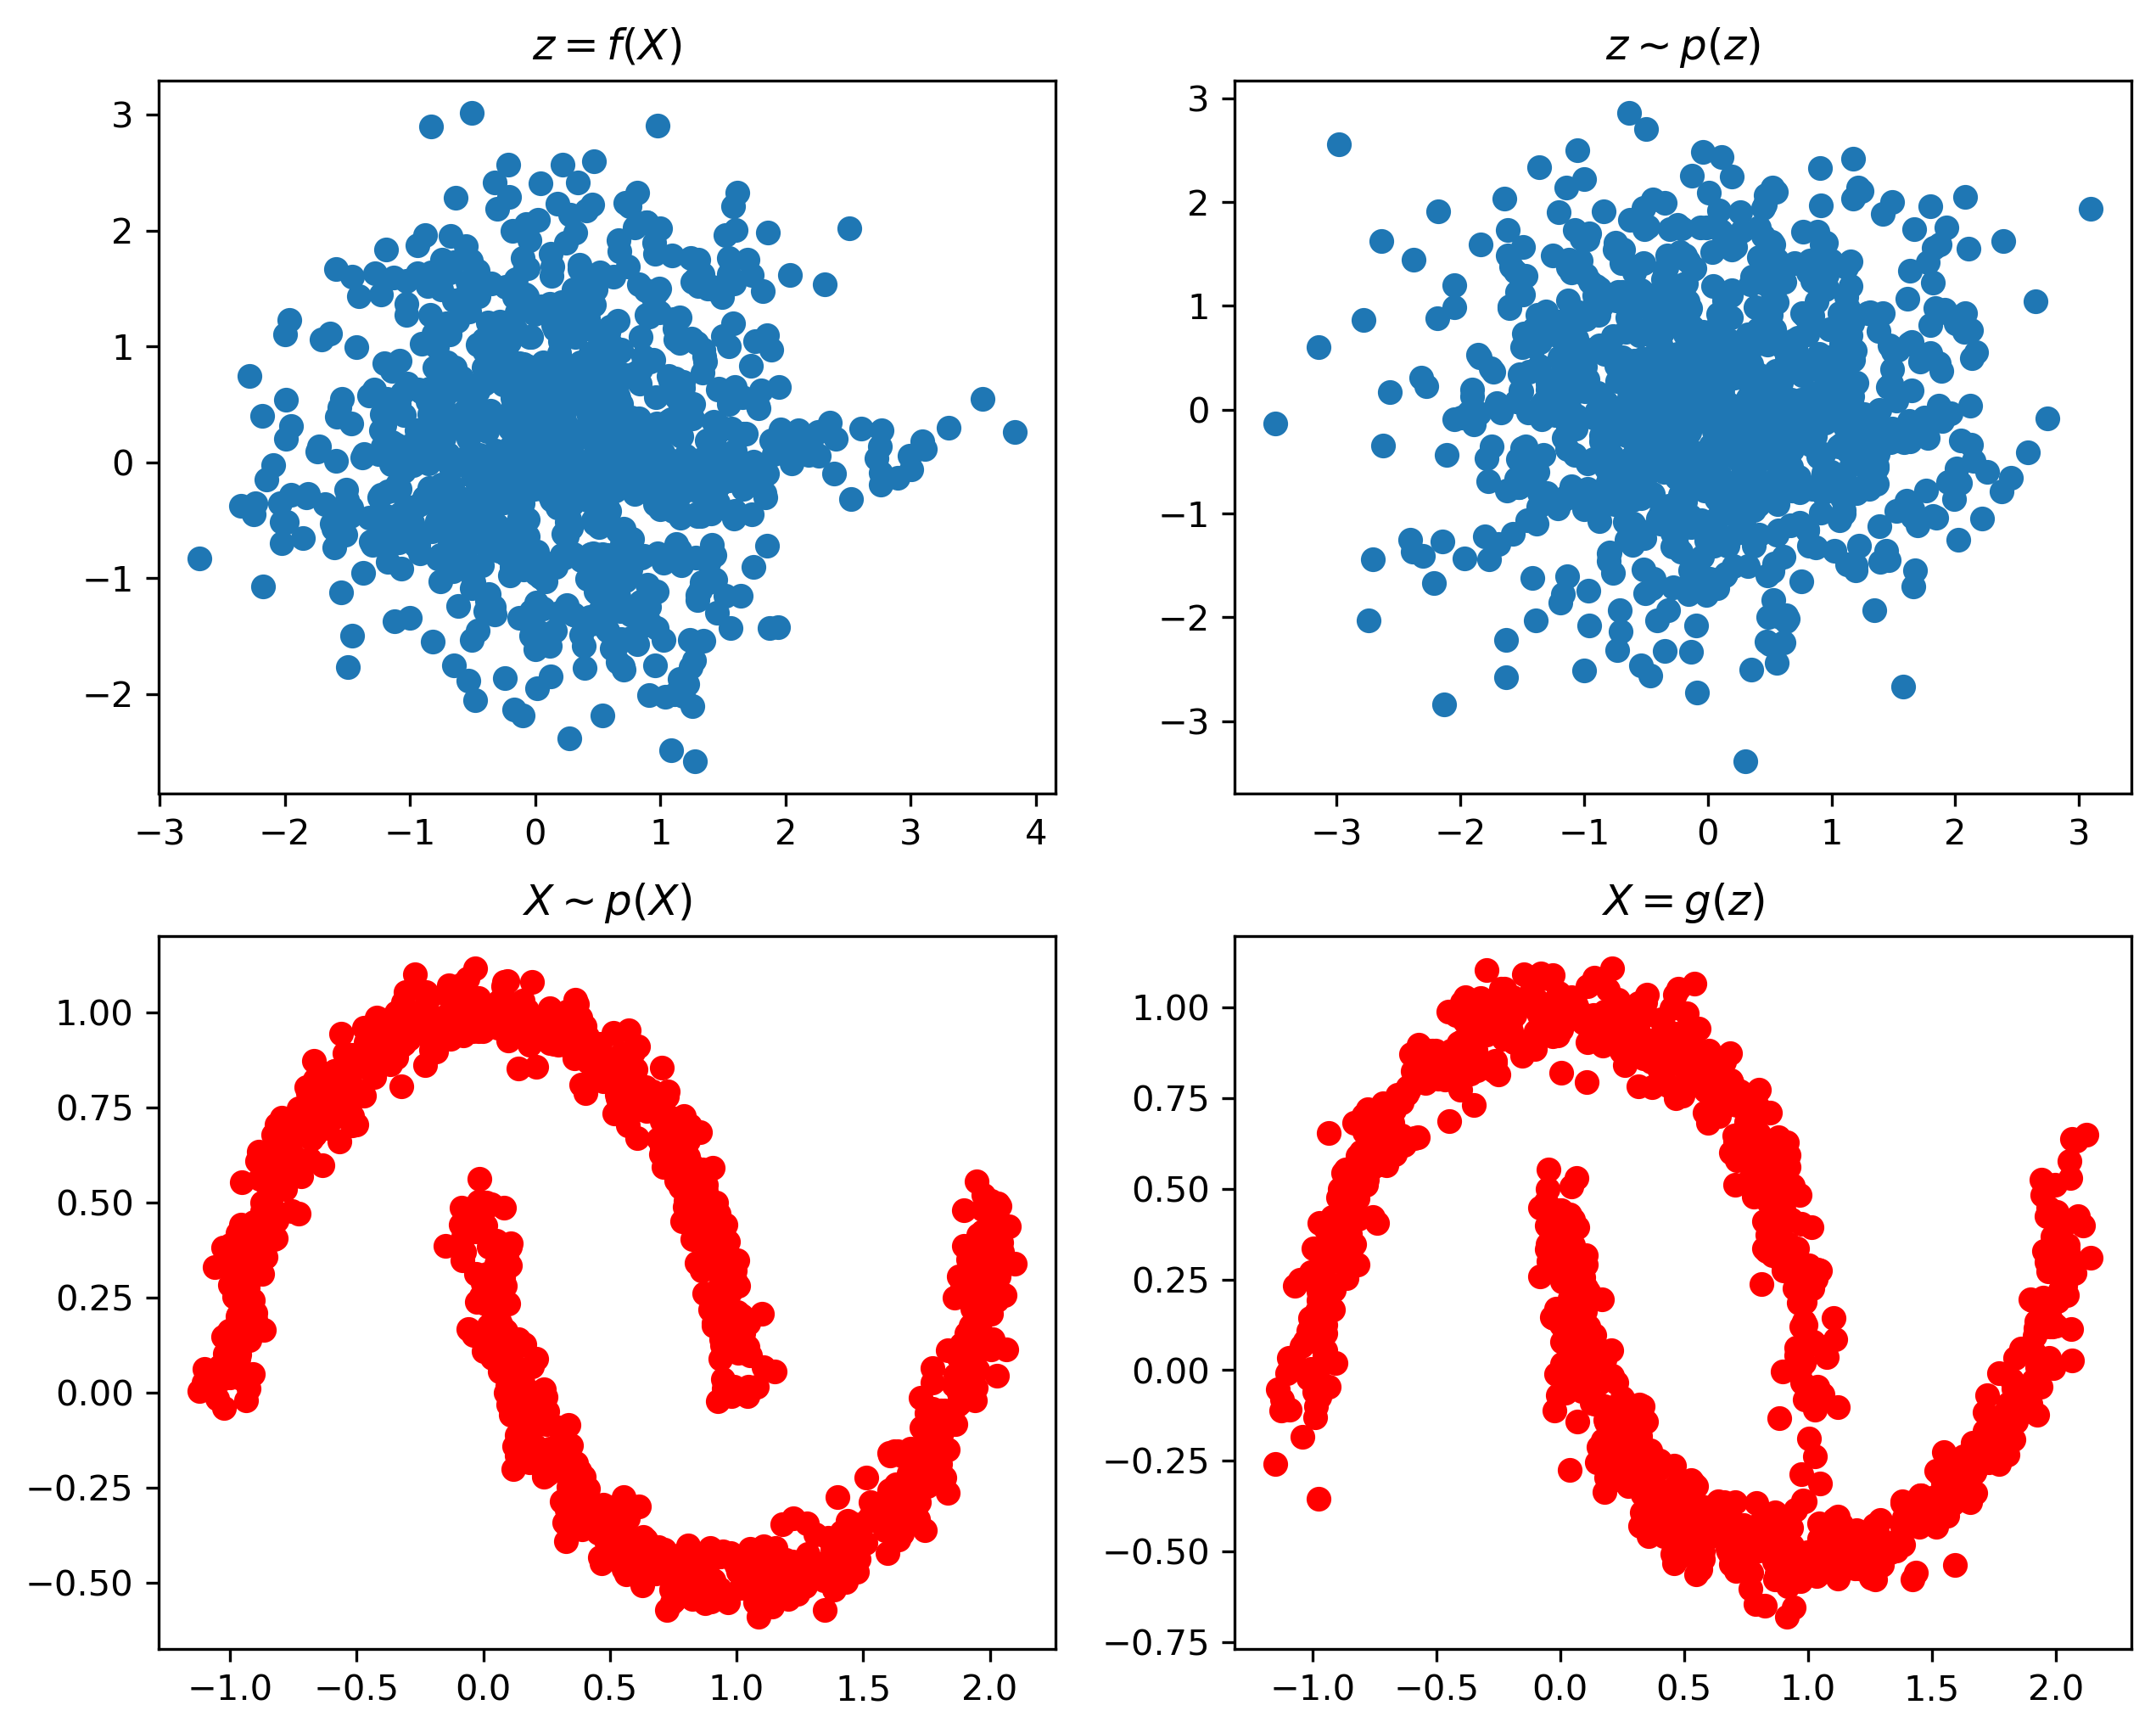

In [65]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

## WITH NFLOWS

In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation
from nflows.nn.nets import ResidualNet

In [3]:
num_layers = 5
base_dist = ConditionalDiagonalNormal(shape=[2], 
                                      context_encoder=nn.Linear(1, 4))

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4, 
                                                          context_features=1))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [4]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(128, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
    
    print(x.shape, y.shape)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x, context=y).mean()
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        fig, ax = plt.subplots(1, 2)
        xline = torch.linspace(-1.5, 2.5,100)
        yline = torch.linspace(-.75, 1.25,100)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid0 = flow.log_prob(xyinput, torch.zeros(10000, 1)).exp().reshape(100, 100)
            zgrid1 = flow.log_prob(xyinput, torch.ones(10000, 1)).exp().reshape(100, 100)

        ax[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid0.numpy())
        ax[1].contourf(xgrid.numpy(), ygrid.numpy(), zgrid1.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()


torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([128, 1])
torch.Size([128, 2]) torch.Size([1


KeyboardInterrupt

